In [13]:
import re
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict
plt.style.use('default')
CSV_EXTENSION = '.csv'
SINGLE_FILE_KEY = 'single_file'
import warnings
warnings.filterwarnings('ignore')

def process_horizon_categories_output(row):
    # Check if the row is a string
    if isinstance(row, str):
        # Define the regular expression pattern
        pattern = r"(?P<type>\w+) '.*?' used at line (?P<usage_line>\d+) is defined at line (?P<def_line>\d+)"

        # Use the re.findall function to find all matches in the row
        matches = re.findall(pattern, row)

        # Convert the matches to the required format
        results = []
        for match in matches:
            type, usage_line, def_line = match
            results.append((type, int(usage_line), int(def_line)))

        return results
    else:
        # If the row is not a string, return an empty list
        return []

def expand_lists_to_rows(df, column):
    # Create a new DataFrame where each item in the 'Processed' column is expanded into its own row
    expanded_df = df.explode(column)

    # Split the 'Processed' column into separate 'Type', 'usage_line', and 'def_line' columns
    expanded_df[['Type', 'usage_line', 'def_line']] = pd.DataFrame(expanded_df[column].tolist(), index=expanded_df.index)
    
    # Calculate the absolute differences between 'usage_line' and 'def_line'
    expanded_df['abs_diff'] = abs(expanded_df['usage_line'] - expanded_df['def_line'])

    # Drop the 'Processed' column
    expanded_df = expanded_df.drop(columns=[column])

    return expanded_df

def process_max_range(expanded_df, groupby_col=['code_task', 'start_line', 'end_line']):
    # Drop NaN values
    expanded_df = expanded_df.dropna(subset=groupby_col)
    # Reset the index
    expanded_df = expanded_df.reset_index(drop=True)
    # Find the index of the row with the maximum difference for each group
    idx = expanded_df.groupby(groupby_col)['abs_diff'].idxmax()
    # Print out the number of rows in the original DataFrame, dropped, and the number of rows after the groupby operation
    print(f"Original DataFrame: {len(expanded_df)} rows")
    # print(f"Rows dropped: {len(expanded_df) - len(idx)}")
    print(f"DataFrame after groupby: {len(idx)} rows")
    # Keep only the rows with the maximum difference
    expanded_df = expanded_df.loc[idx]
    return expanded_df

def extract_info(csv_file):
    # Remove the file extension
    name_without_ext = csv_file.split('.csv')[0]

    # Split the name into parts
    parts = name_without_ext.split('_')

    # Extract the information
    info = {
        'model_name': parts[0],
        'gen_mode': '_'.join(parts[1:3]),
        'task': parts[3],
        'time': '_'.join(parts[4:])
    }

    return info

def group_by_res(folder_path, group_by_keys=['model_name','gen_mode'], group_gpt_4_turbo=True):
    # Get a list of all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Create a dictionary to store the groups
    groups = defaultdict(list)

    # Group the CSV files
    for csv_file in csv_files:
        # Extract the information from the file name
        info = extract_info(csv_file)

        # Get the group key
        group_key_parts = [info[key] for key in group_by_keys]
        group_key = '_'.join(group_key_parts)

        # If group_gpt_4_turbo is True, treat 'gpt-4-turbo' and 'gpt-4-turbo-2024-04-09' as the same model_name
        if group_gpt_4_turbo and 'model_name' in group_by_keys and 'gpt-4-turbo' in group_key:
            group_key = group_key.replace('gpt-4-turbo-2024-04-09', 'gpt-4-turbo')

        # Add the CSV file to the group
        groups[group_key].append(csv_file)

    # Concatenate the CSV files in each group
    for group_key, group_files in groups.items():
        print(f"Grouped by {group_by_keys} and combined {', '.join(group_files)}")
        dfs = [pd.read_csv(os.path.join(folder_path, csv_file)) for csv_file in group_files]
        df_group = pd.concat(dfs, ignore_index=True)
        groups[group_key] = df_group

    return groups

def groupby_sanity_check(grouped_dfs):
    for group_key, df in grouped_dfs.items():
        print(f"Group Key: {group_key}")
        print(len(df))
        print("\n")
        
def process_folder(folder_path: str) -> Dict[str, pd.DataFrame]:
    global col_to_check
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Group and concatenate the CSV files
        grouped_dfs = group_by_res(folder_path)
    elif os.path.isfile(folder_path) and folder_path.endswith(CSV_EXTENSION):
        # If the path is a CSV file, read it into a DataFrame
        grouped_dfs = {SINGLE_FILE_KEY: pd.read_csv(folder_path)}
    else:
        # If the path is not a directory and not a CSV file, raise an error
        raise ValueError(f"Invalid path: {folder_path}. Path must be a directory containing CSV files or a CSV file.")
    processed_dfs = {}
    for group_key, df in grouped_dfs.items():
        init_row_num = len(df)
        # Columns to check for NaN values
        initial_cols_to_check = ['horizon_categories_output', 'horizon_freq_analysis']

        # Drop rows with NaN values in the initial_cols_to_check
        df_after_initial_drop = df.dropna(subset=initial_cols_to_check)

        # Process the 'horizon_categories_output' column
        df_after_initial_drop['Processed'] = df_after_initial_drop['horizon_categories_output'].apply(process_horizon_categories_output)

        # Expand the lists to rows
        expanded_df = expand_lists_to_rows(df_after_initial_drop, 'Processed')

        # Additional columns to check for NaN values
        additional_cols_to_check = ['horizon_categories_output', 'horizon_freq_analysis', 'Type', 'usage_line', 'def_line', 'abs_diff', col_to_check]

        # Drop rows with NaN values in the additional_cols_to_check
        expanded_df_filtered = expanded_df.dropna(subset=additional_cols_to_check)

        print("#############################################")
        # Print out the number of rows in the original DataFrame, and dropped due to NaN values in the cols_to_check
        print(f"Original DataFrame: {init_row_num} rows")
        print(f"Rows dropped due to NaN in initial columns {initial_cols_to_check}: {init_row_num - len(df_after_initial_drop)}")
        print(f"Rows after expansion: {len(expanded_df)} rows")
        print(f"Rows dropped due to NaN in additional columns {additional_cols_to_check}: {len(expanded_df) - len(expanded_df_filtered)}")

        # Process the max range
        df = process_max_range(expanded_df_filtered)

        processed_dfs[group_key] = df

    return processed_dfs

def convert_to_float(val: str) -> float:
    try:
        return float(val)
    except ValueError:
        parts = val.split('/')
        if len(parts) == 2:
            num, denom = parts
            if denom != '0':
                return float(num) / float(denom)
        return 0.0
    
def draw_histogram(df, group_key, show_pass_dist=False, bins=30):
    global col_to_check
    plt.figure(dpi=400)
    # Calculate the absolute differences between 'usage_line' and 'def_line'
    differences = df['abs_diff']

    # Define the bin edges
    bin_edges = np.linspace(differences.min(), differences.max(), bins+1)

    # Create a histogram of the differences
    plt.hist(differences, bins=bin_edges, edgecolor='black', alpha=0.5, label='All data')

    if show_pass_dist:
        # Convert 'col_to_check' to float and filter the DataFrame where it is 1
        df[col_to_check] = df[col_to_check].apply(convert_to_float)
        filtered_df = df[df[col_to_check] == 1]

        # Create a histogram of the differences for the filtered DataFrame
        plt.hist(filtered_df['abs_diff'], bins=bin_edges, edgecolor='black', color='red', alpha=0.5, label='gen_code_passed')

    # Set the title and labels
    plt.title(group_key)
    plt.xlabel('Recall Distance')
    plt.ylabel('Frequency')

    # Add a legend
    plt.legend()

    # Display the histogram
    plt.show()

def plot_histograms(groups, show_pass_dist=True):
    global col_to_check
    for group_key, df_group in groups.items():
        print(f"Plotting histogram for group: {group_key}")
        draw_histogram(df_group, group_key, show_pass_dist)

def classify_and_calculate(df, short_range, medium_range, report_err_bar=True):
    global col_to_check
    def classify_abs_diff(x):
        if x <= short_range:
            return 'Short'
        elif x <= medium_range:
            return 'Medium'
        else:
            return 'Long'

    df['range_class'] = df['abs_diff'].apply(classify_abs_diff)
    df[col_to_check] = df[col_to_check].apply(convert_to_float)

    total_counts = df.groupby('range_class').size()
    pass_counts = df[df[col_to_check] == 1].groupby('range_class').size()
    # Reindex the pass_counts to include all range classes & fill 0 for NaN values
    pass_counts = pass_counts.reindex(total_counts.index, fill_value=0)
    if report_err_bar:
        percentages, err_bar = cal_err_bar(pass_counts, total_counts)
        err_bar = err_bar.values
    else:
        percentages = pass_counts / total_counts * 100
        err_bar = None

    result_df = pd.DataFrame({
        'range_class': total_counts.index,
        'total_counts': total_counts.values,
        'passed_counts': pass_counts.values,
        'percentages': percentages.values
    })

    result_df['range_class'] = pd.Categorical(result_df['range_class'], categories=['Short', 'Medium', 'Long'], ordered=True)
    result_df = result_df.sort_values('range_class')
    # result_df['percentages'] = result_df['percentages'].apply(lambda x: '{0:.3f}%'.format(x))
    if report_err_bar:
        result_df['percentages'] = result_df.apply(lambda row: f"{row['percentages']*100:.2f} ± {err_bar[row.name]*100:.2f}", axis=1)
    else:
        result_df['percentages'] = result_df['percentages'].apply(lambda x: f"{x:.2f}%")

    return percentages, result_df

# percentages, result_df = classify_and_calculate(combined_df['gpt-4-turbo_with_afterlines'], 30, 100)
# result_df

def process_all_dfs(combined_df, short_range, medium_range):
    all_results = []
    for key in combined_df:
        percentages, result_df = classify_and_calculate(combined_df[key], short_range, medium_range)
        result_df.insert(0, 'key', key)
        all_results.append(result_df)
    final_df = pd.concat(all_results, ignore_index=True)
    return final_df

def split_df(final_df):
    unique_keys = final_df['key'].unique()
    sub_dfs = {key: final_df[final_df['key'] == key].drop(columns='key') for key in unique_keys}
    return sub_dfs

def process_and_plot(folder_path, col_to_check):
    # Set the global variable
    combined_df = process_folder(folder_path)
    # Call the function
    plot_histograms(combined_df)
    return combined_df

def process_and_display(combined_df, short_range, medium_range):
    # Set the short and medium ranges
    final_df = process_all_dfs(combined_df, short_range, medium_range)

    sub_dfs = split_df(final_df)

    # Sort the keys based on model_name and gen_mode
    sorted_keys = sorted(sub_dfs.keys(), key=lambda x: (x.rsplit('_', 1)[0], x.rsplit('_', 1)[1]))

    for key in sorted_keys:
        df = sub_dfs[key]
        print(f"Key: {key}")
        display(df)

def bootstrap_resampling(pass_count, total_count, num_resamples=10000):
    # Calculate model's performance
    performance = pass_count / total_count

    # Generate bootstrap resamples
    resamples = np.random.choice([0, 1], size=(num_resamples, total_count), p=[1-performance, performance])

    # Calculate pass count for each resample
    resample_pass_counts = resamples.sum(axis=1)

    # Calculate performance for each resample
    resample_performances = resample_pass_counts / total_count

    # Calculate average and 1.96 standard deviations of resample performances
    avg_performance = resample_performances.mean()
    std_dev_performance = resample_performances.std()

    return avg_performance, 1.96 * std_dev_performance

def cal_err_bar(pass_counts, total_counts, num_resamples=10000):
    percentages = []
    err_bars = []
    for pass_count, total_count in zip(pass_counts, total_counts):
        # Use bootstrap resampling to calculate average performance and error bar
        percentage, err_bar = bootstrap_resampling(pass_count, total_count, num_resamples)
        percentages.append(percentage)
        err_bars.append(err_bar)

    return pd.Series(percentages, index=total_counts.index), pd.Series(err_bars, index=total_counts.index)
# #################################
# #Java All Res
# ##########################
# # folder_path = '../Analysis_Results/storage_server/Java_all_res/Completion/4th_post_process_reason_update/Update_labels'
# folder_path = '../Analysis_Results/storage_server/Java_all_res/Infilling/4th_post_process_reason_update/Update_labels'


# # Set the global variable
# # col_to_check = 'gen_code_pass_ratio'
# col_to_check = 'post_process_pass_ratio'
# combined_df = process_and_plot(folder_path, col_to_check)


# # Set the short and medium ranges
# # Potential Setting for Java
# process_and_display(combined_df, 30, 100)
# # Potential Setting for Python
# # process_and_display(combined_df, 10, 30)

Grouped by ['model_name', 'gen_mode'] and combined gpt-4-turbo_no_afterlines_MTreeTester_06_03_04_07.csv, gpt-4-turbo_no_afterlines_FactorizationTester_06_03_04_05.csv, gpt-4-turbo_no_afterlines_SparseArrayTester_06_03_03_58.csv, gpt-4-turbo_no_afterlines_CounterTester_06_03_04_02.csv, gpt-4-turbo_no_afterlines_RNGTester_06_03_04_02.csv, gpt-4-turbo_no_afterlines_DoubleVectorTester_06_03_04_00.csv, gpt-4-turbo_no_afterlines_TopKTester_06_03_04_01.csv, gpt-4-turbo_no_afterlines_DoubleMatrixTester_06_03_04_06.csv
Grouped by ['model_name', 'gen_mode'] and combined Meta-Llama-3-8B-Instruct_no_afterlines_TopKTester_06_03_04_05.csv, Meta-Llama-3-8B-Instruct_no_afterlines_FactorizationTester_06_03_04_03.csv, Meta-Llama-3-8B-Instruct_no_afterlines_SparseArrayTester_06_03_04_03.csv, Meta-Llama-3-8B-Instruct_no_afterlines_DoubleVectorTester_06_03_03_58.csv, Meta-Llama-3-8B-Instruct_no_afterlines_RNGTester_06_03_04_03.csv, Meta-Llama-3-8B-Instruct_no_afterlines_CounterTester_06_03_04_06.csv, Meta

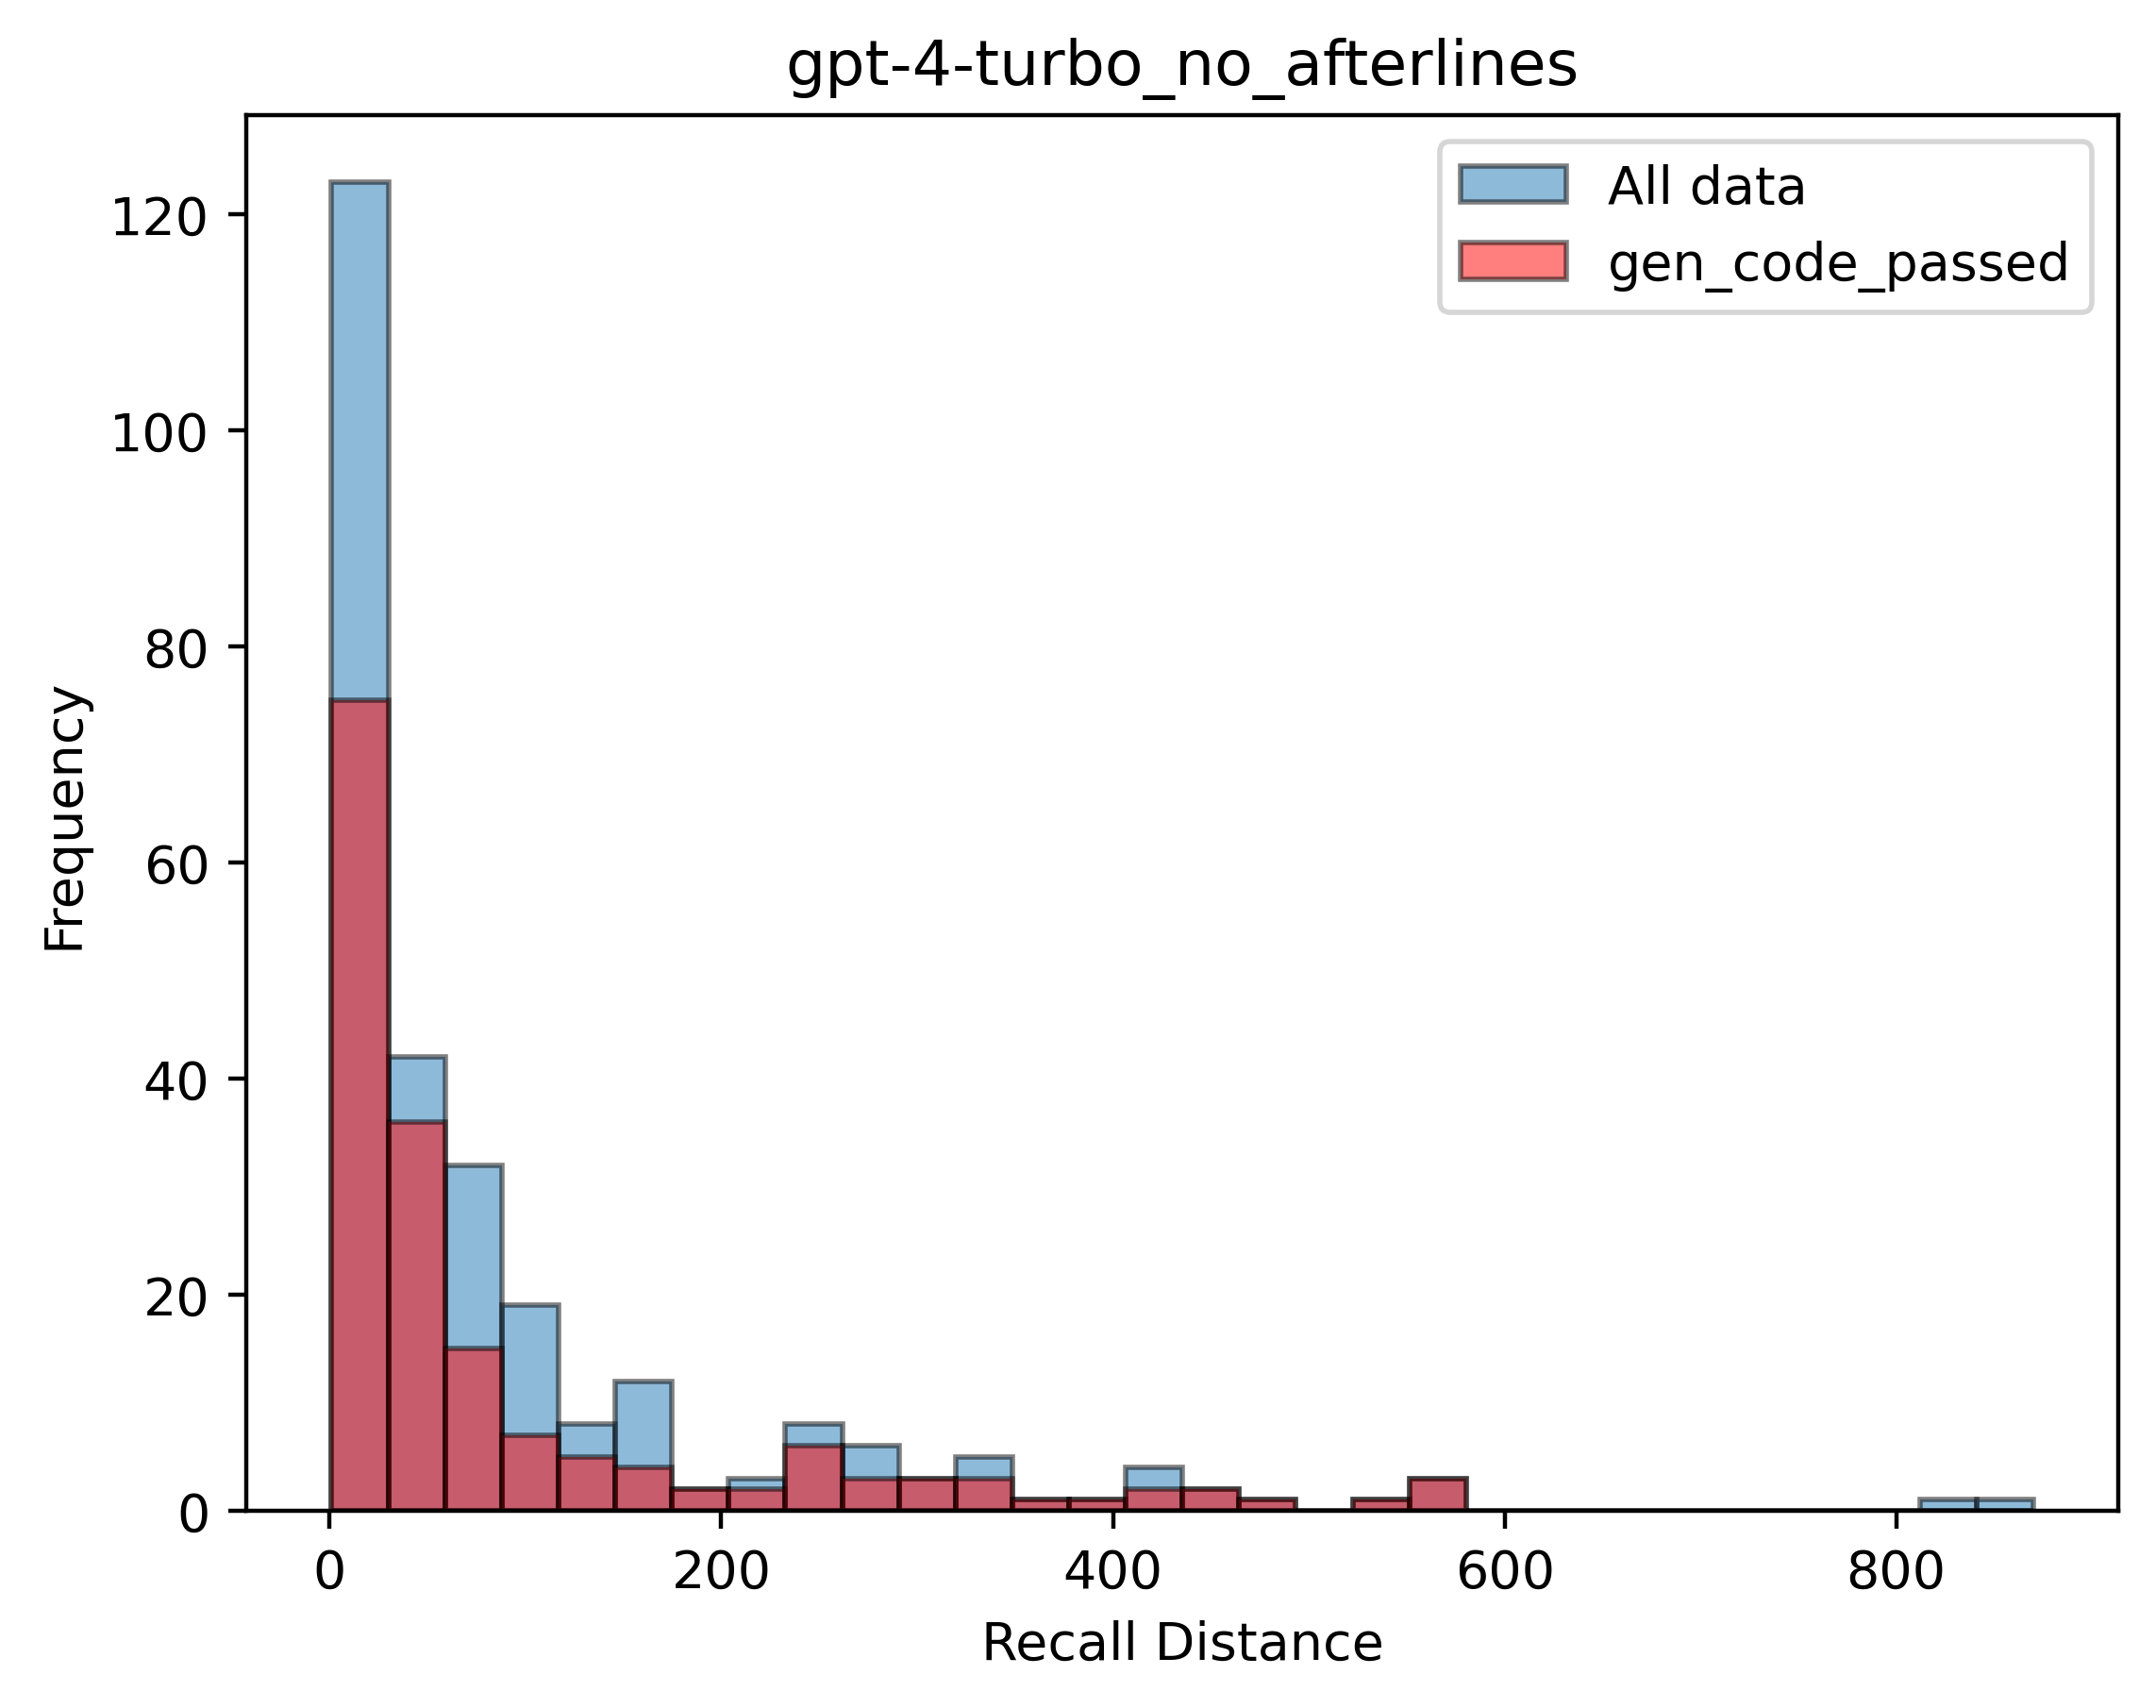

Plotting histogram for group: Meta-Llama-3-8B-Instruct_no_afterlines


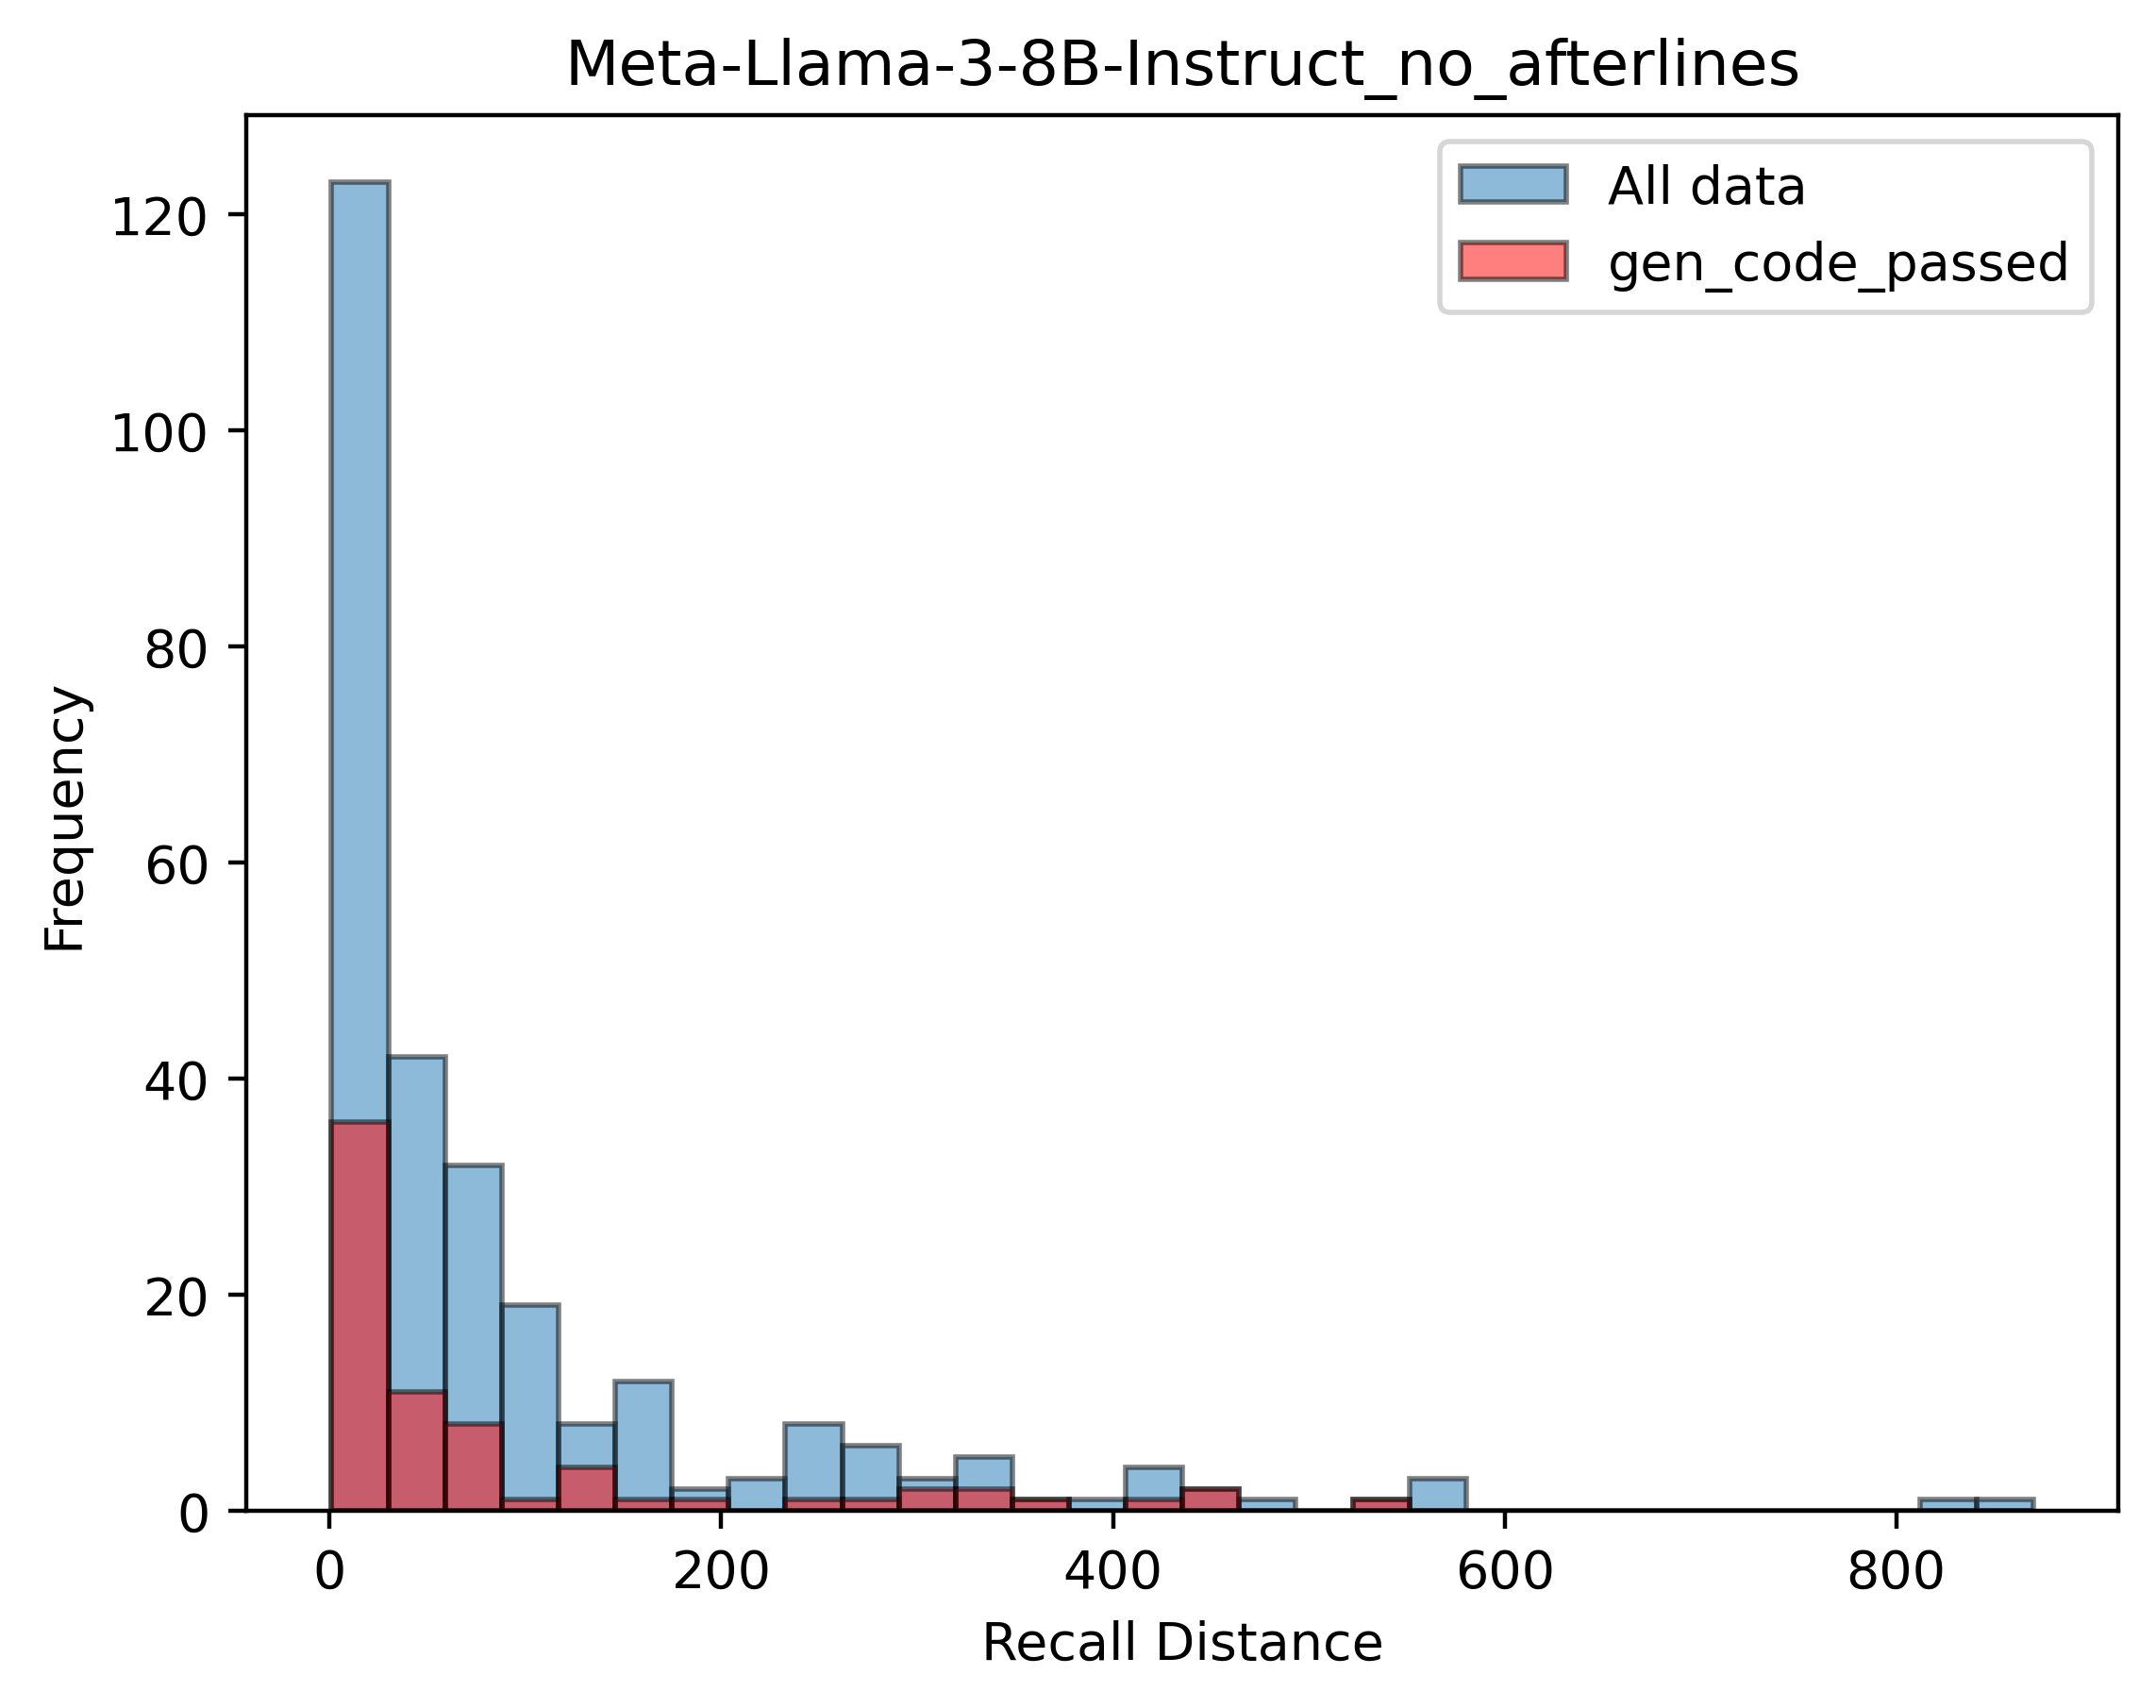

Plotting histogram for group: claude-3-sonnet-20240229_no_afterlines


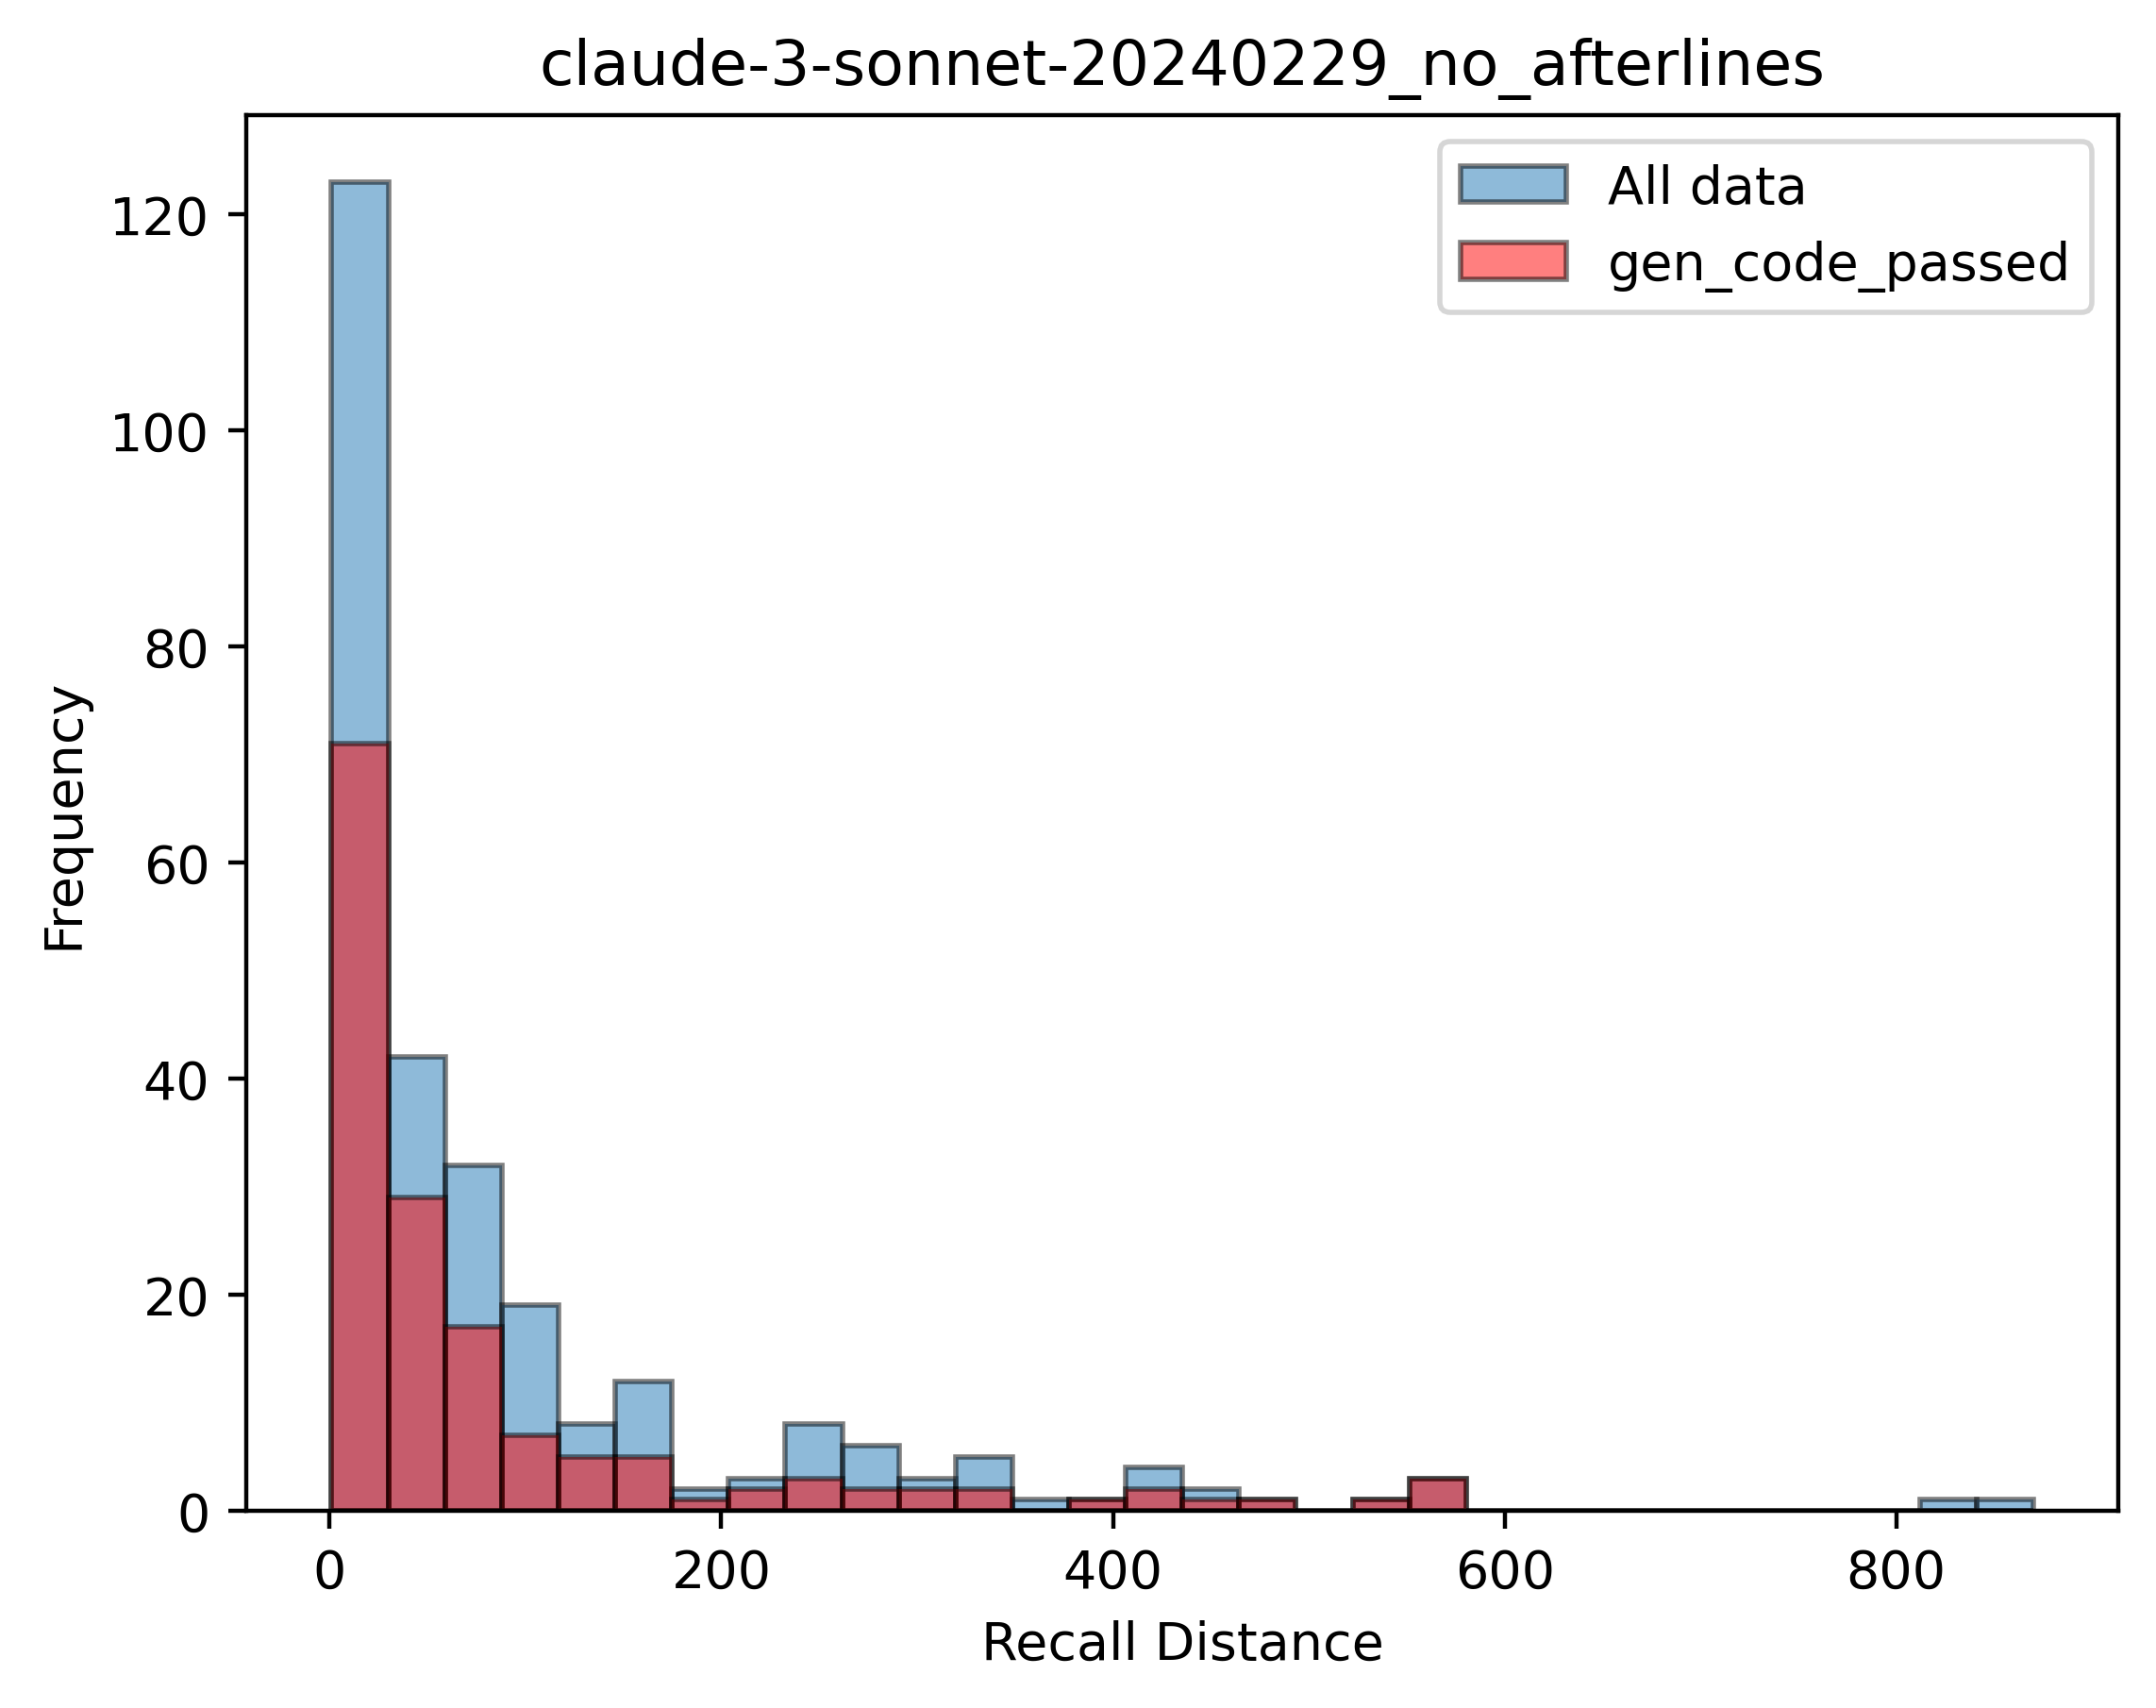

Plotting histogram for group: deepseek-coder-1.3b-instruct_no_afterlines


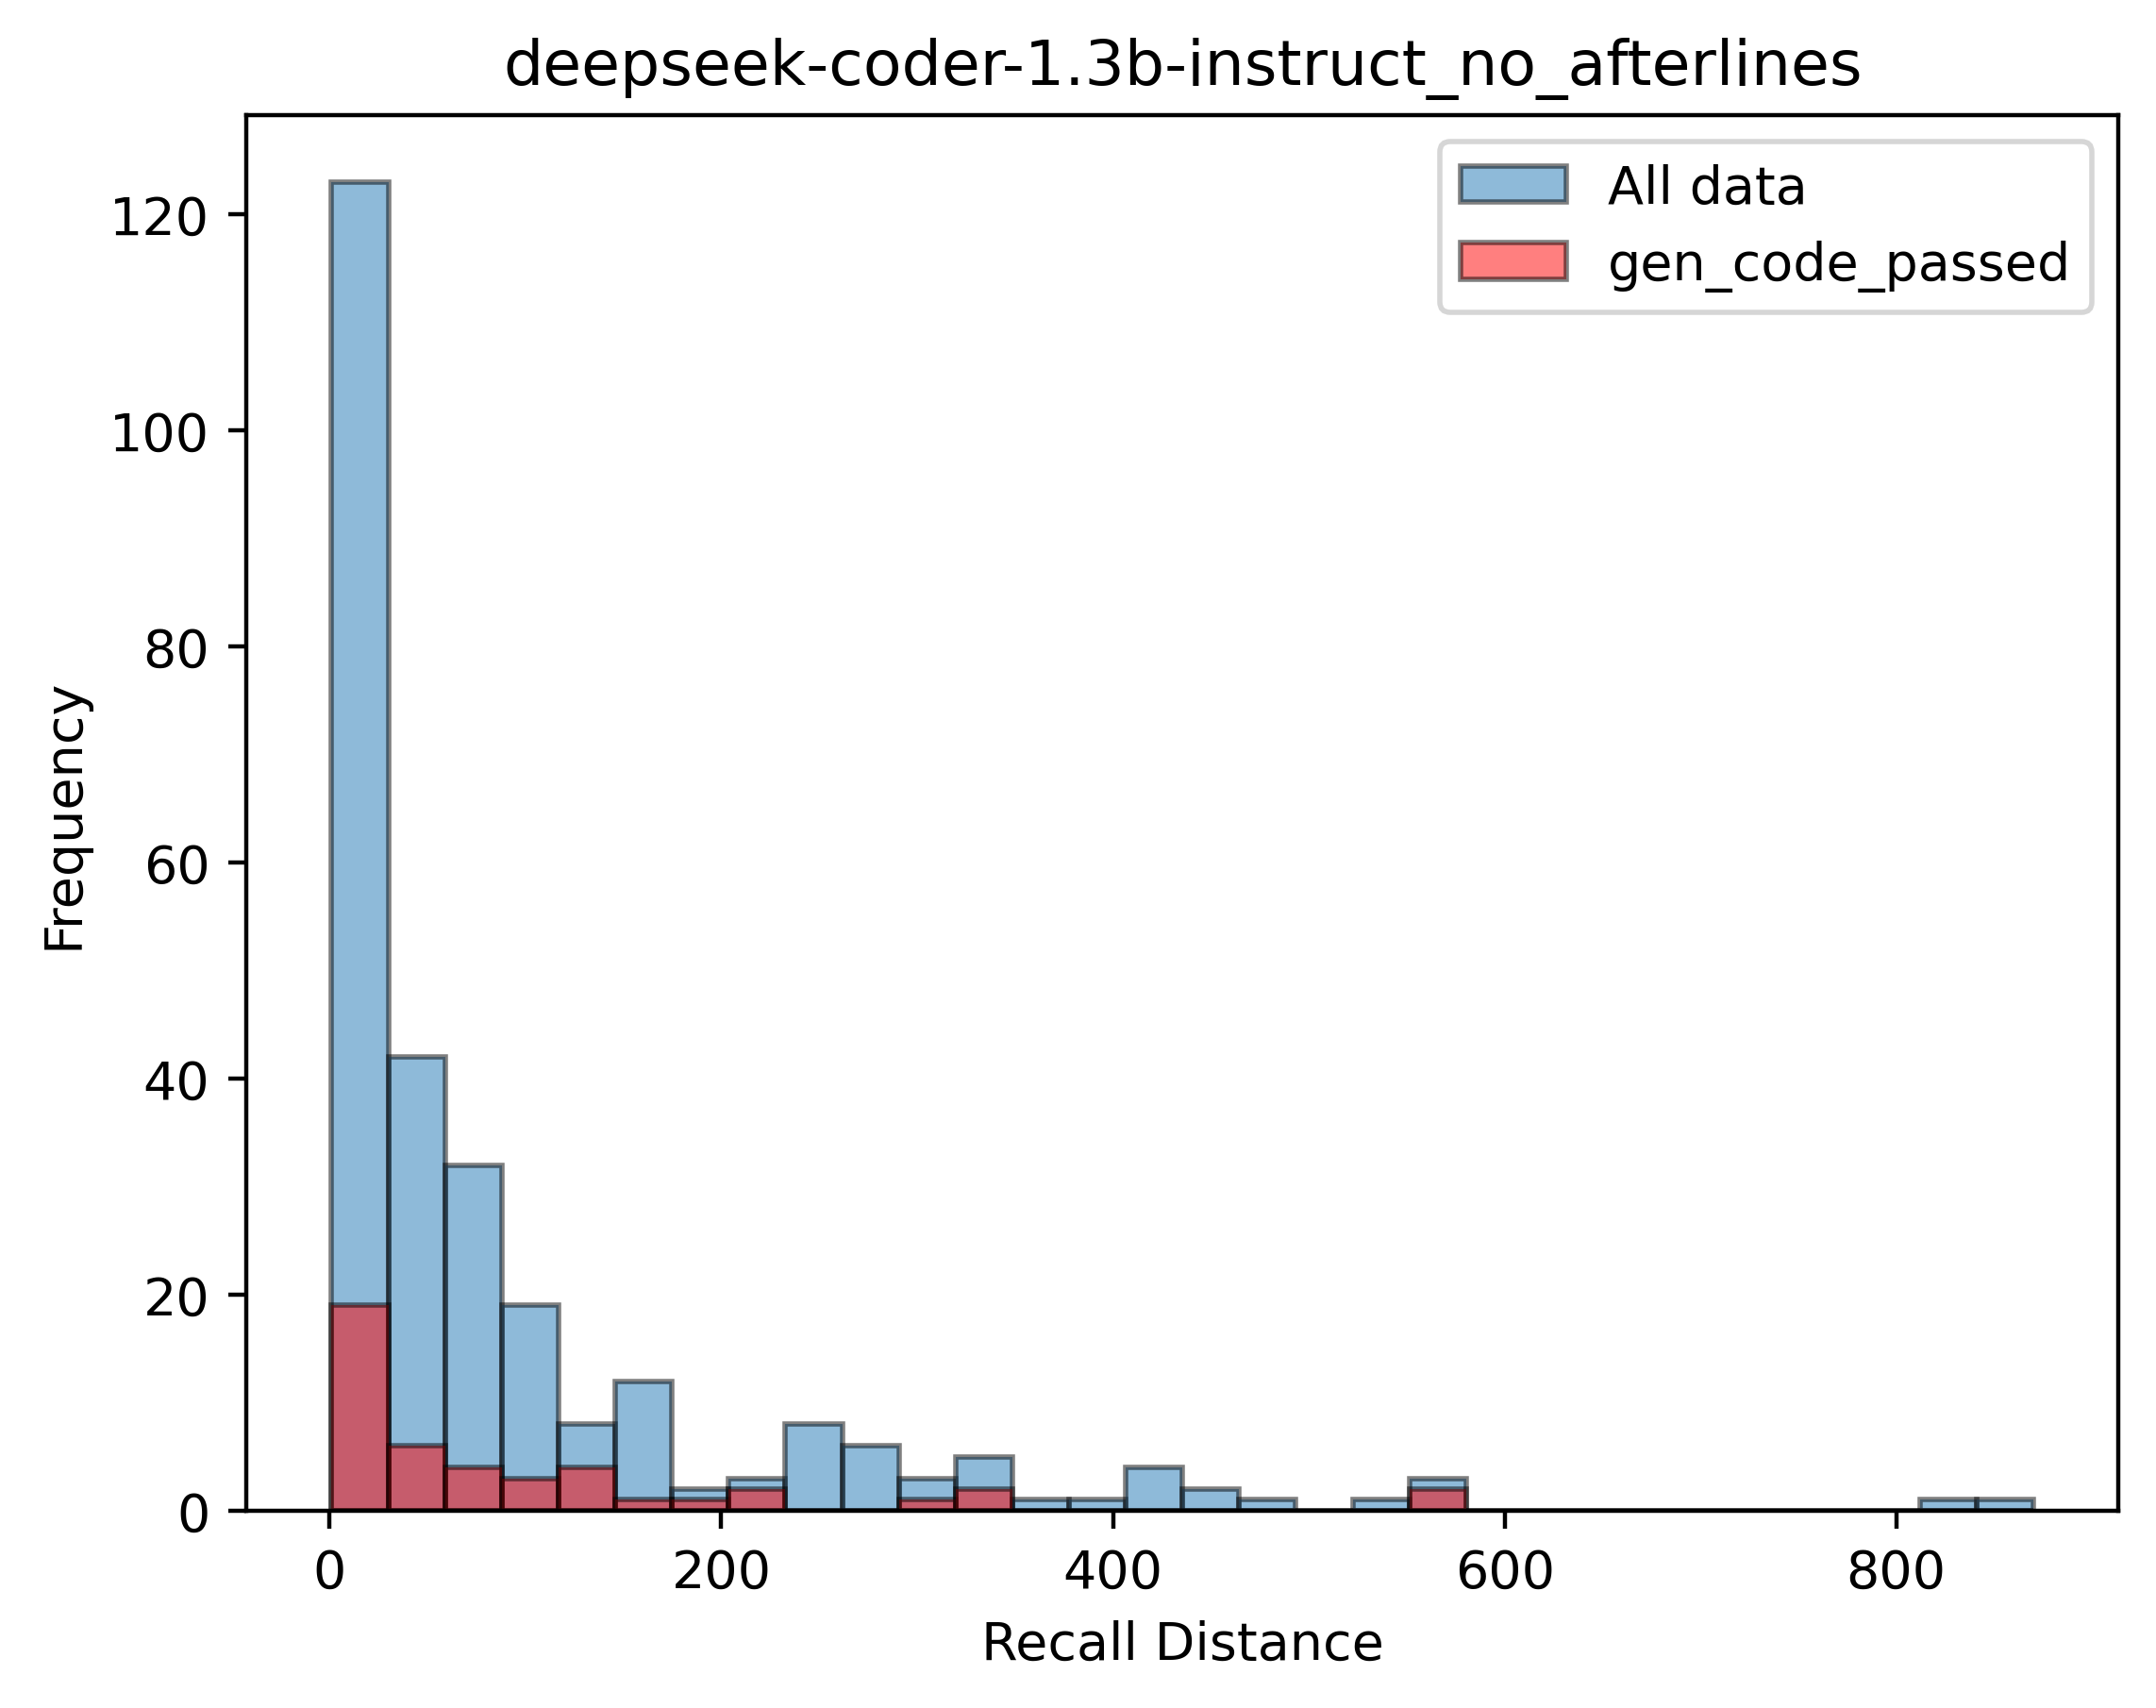

Plotting histogram for group: claude-3-haiku-20240307_no_afterlines


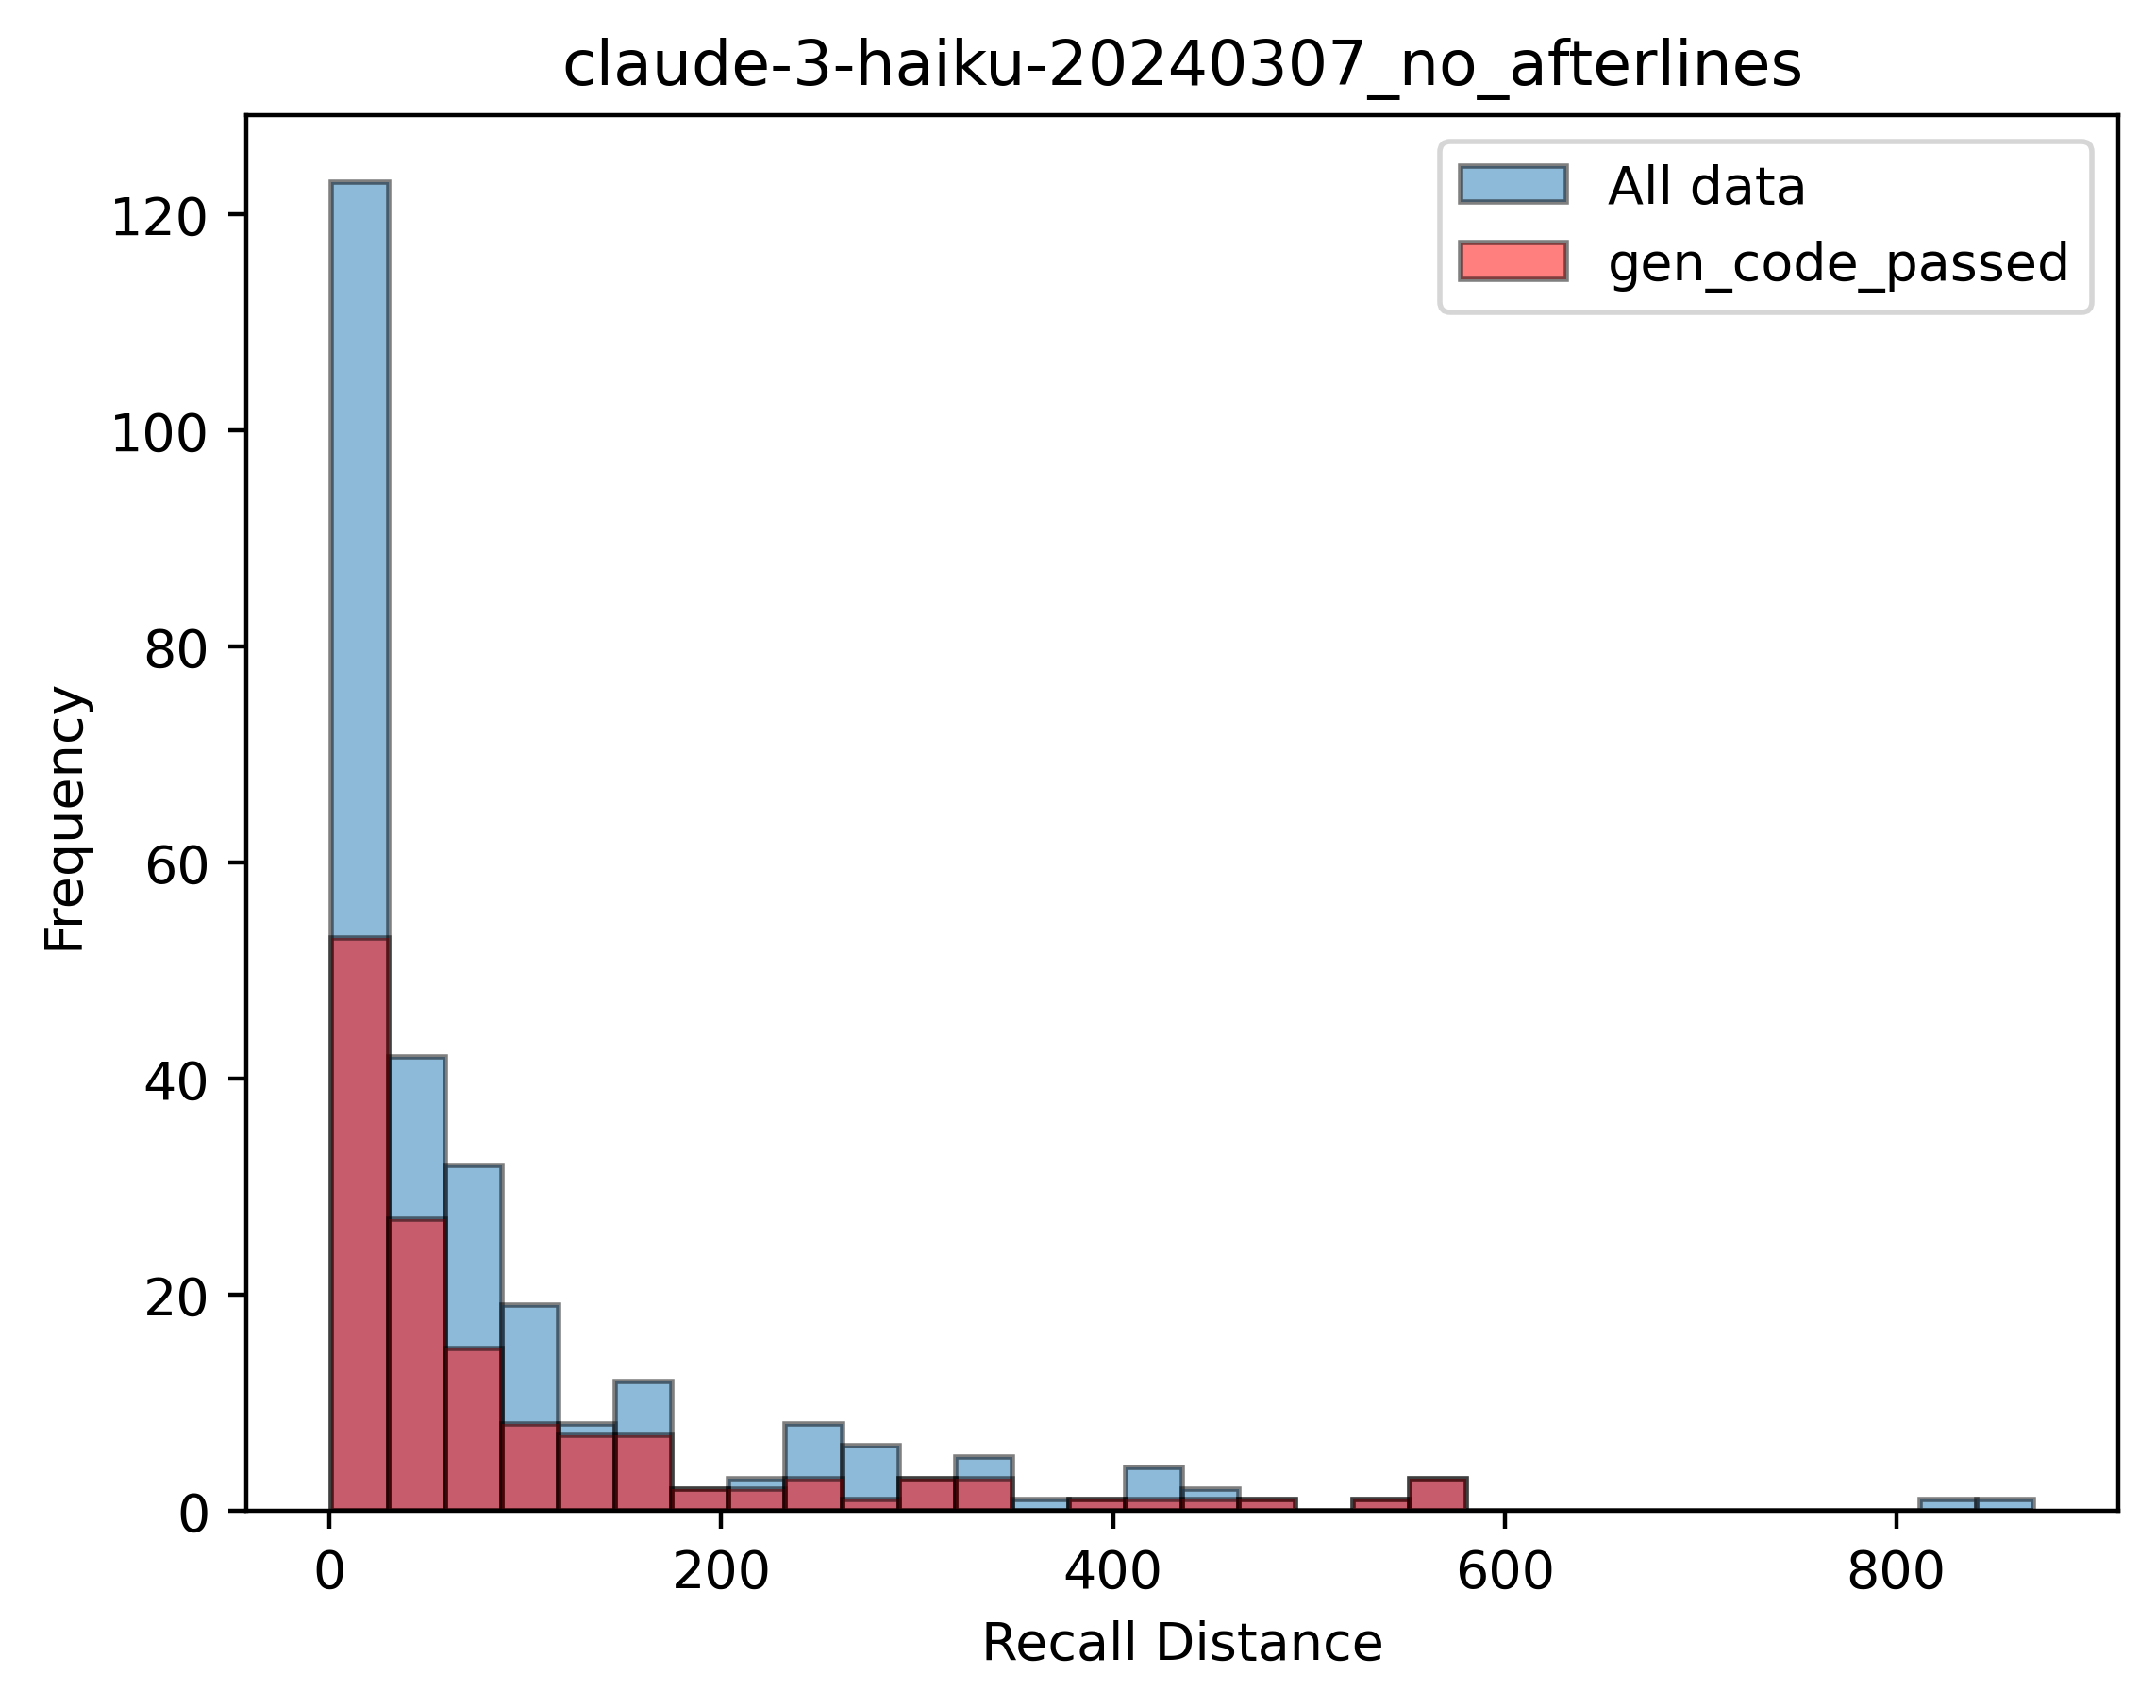

Plotting histogram for group: Meta-Llama-3-70B-Instruct_no_afterlines


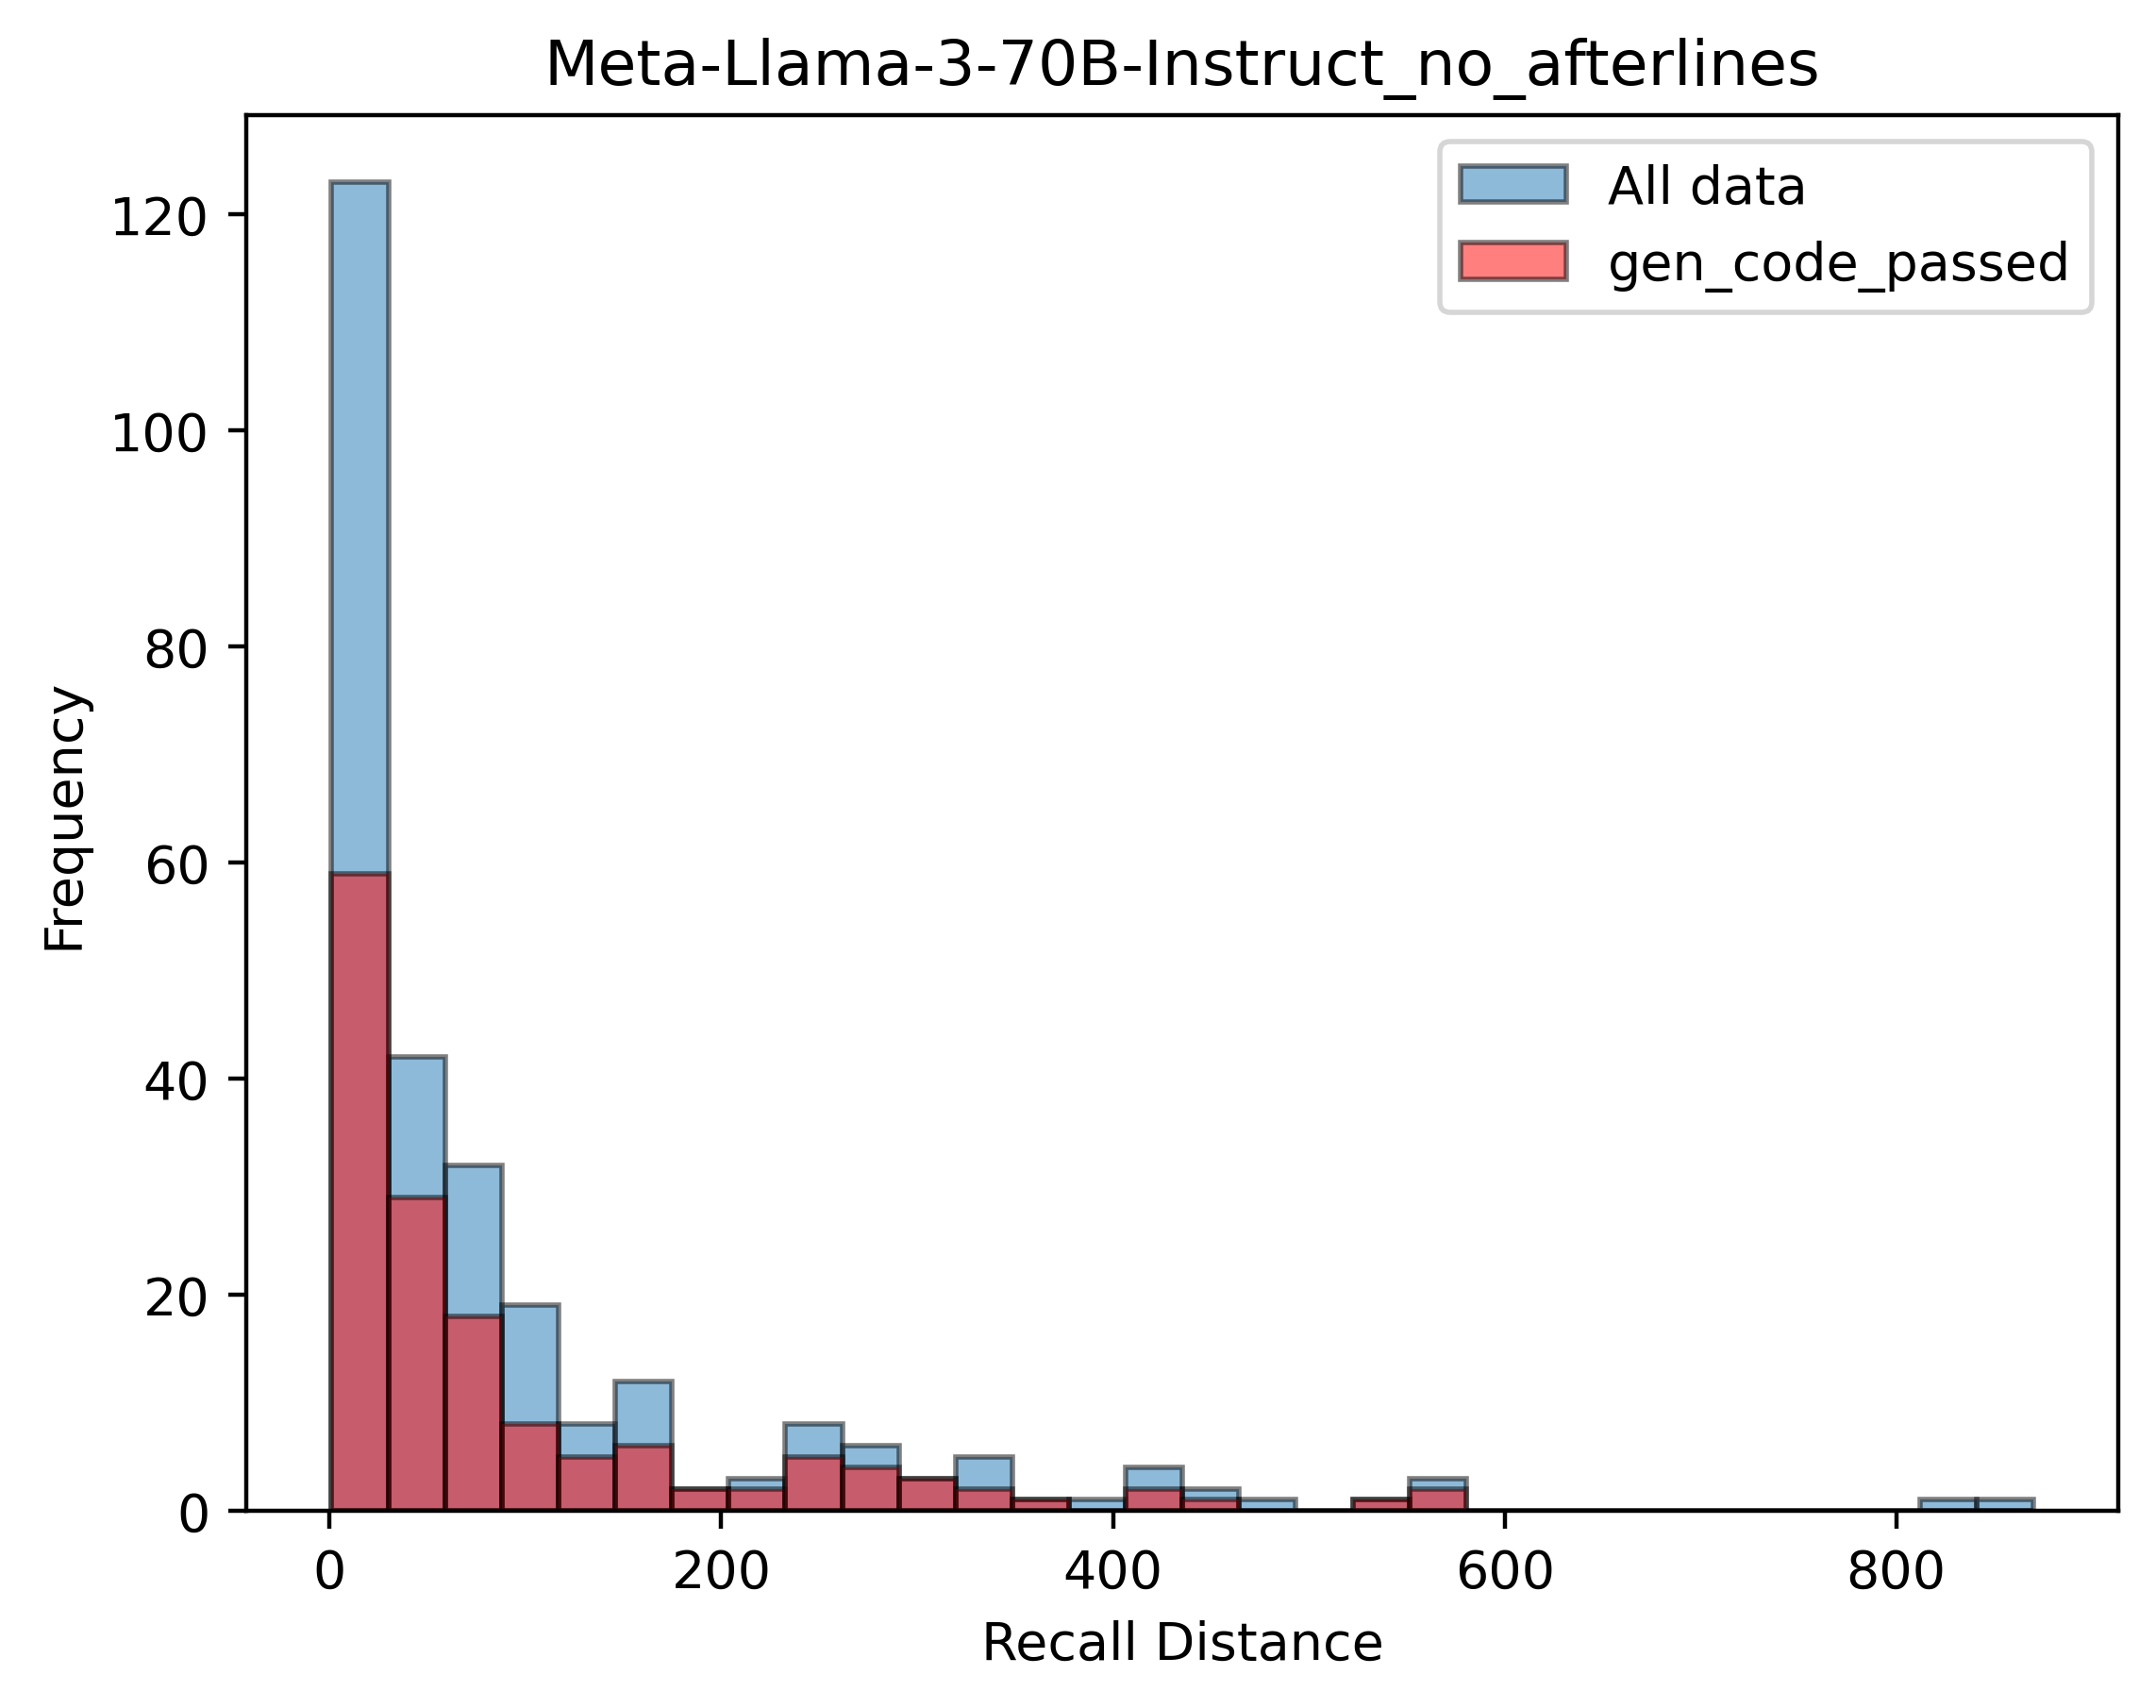

Plotting histogram for group: phi-3-mini-4k_no_afterlines


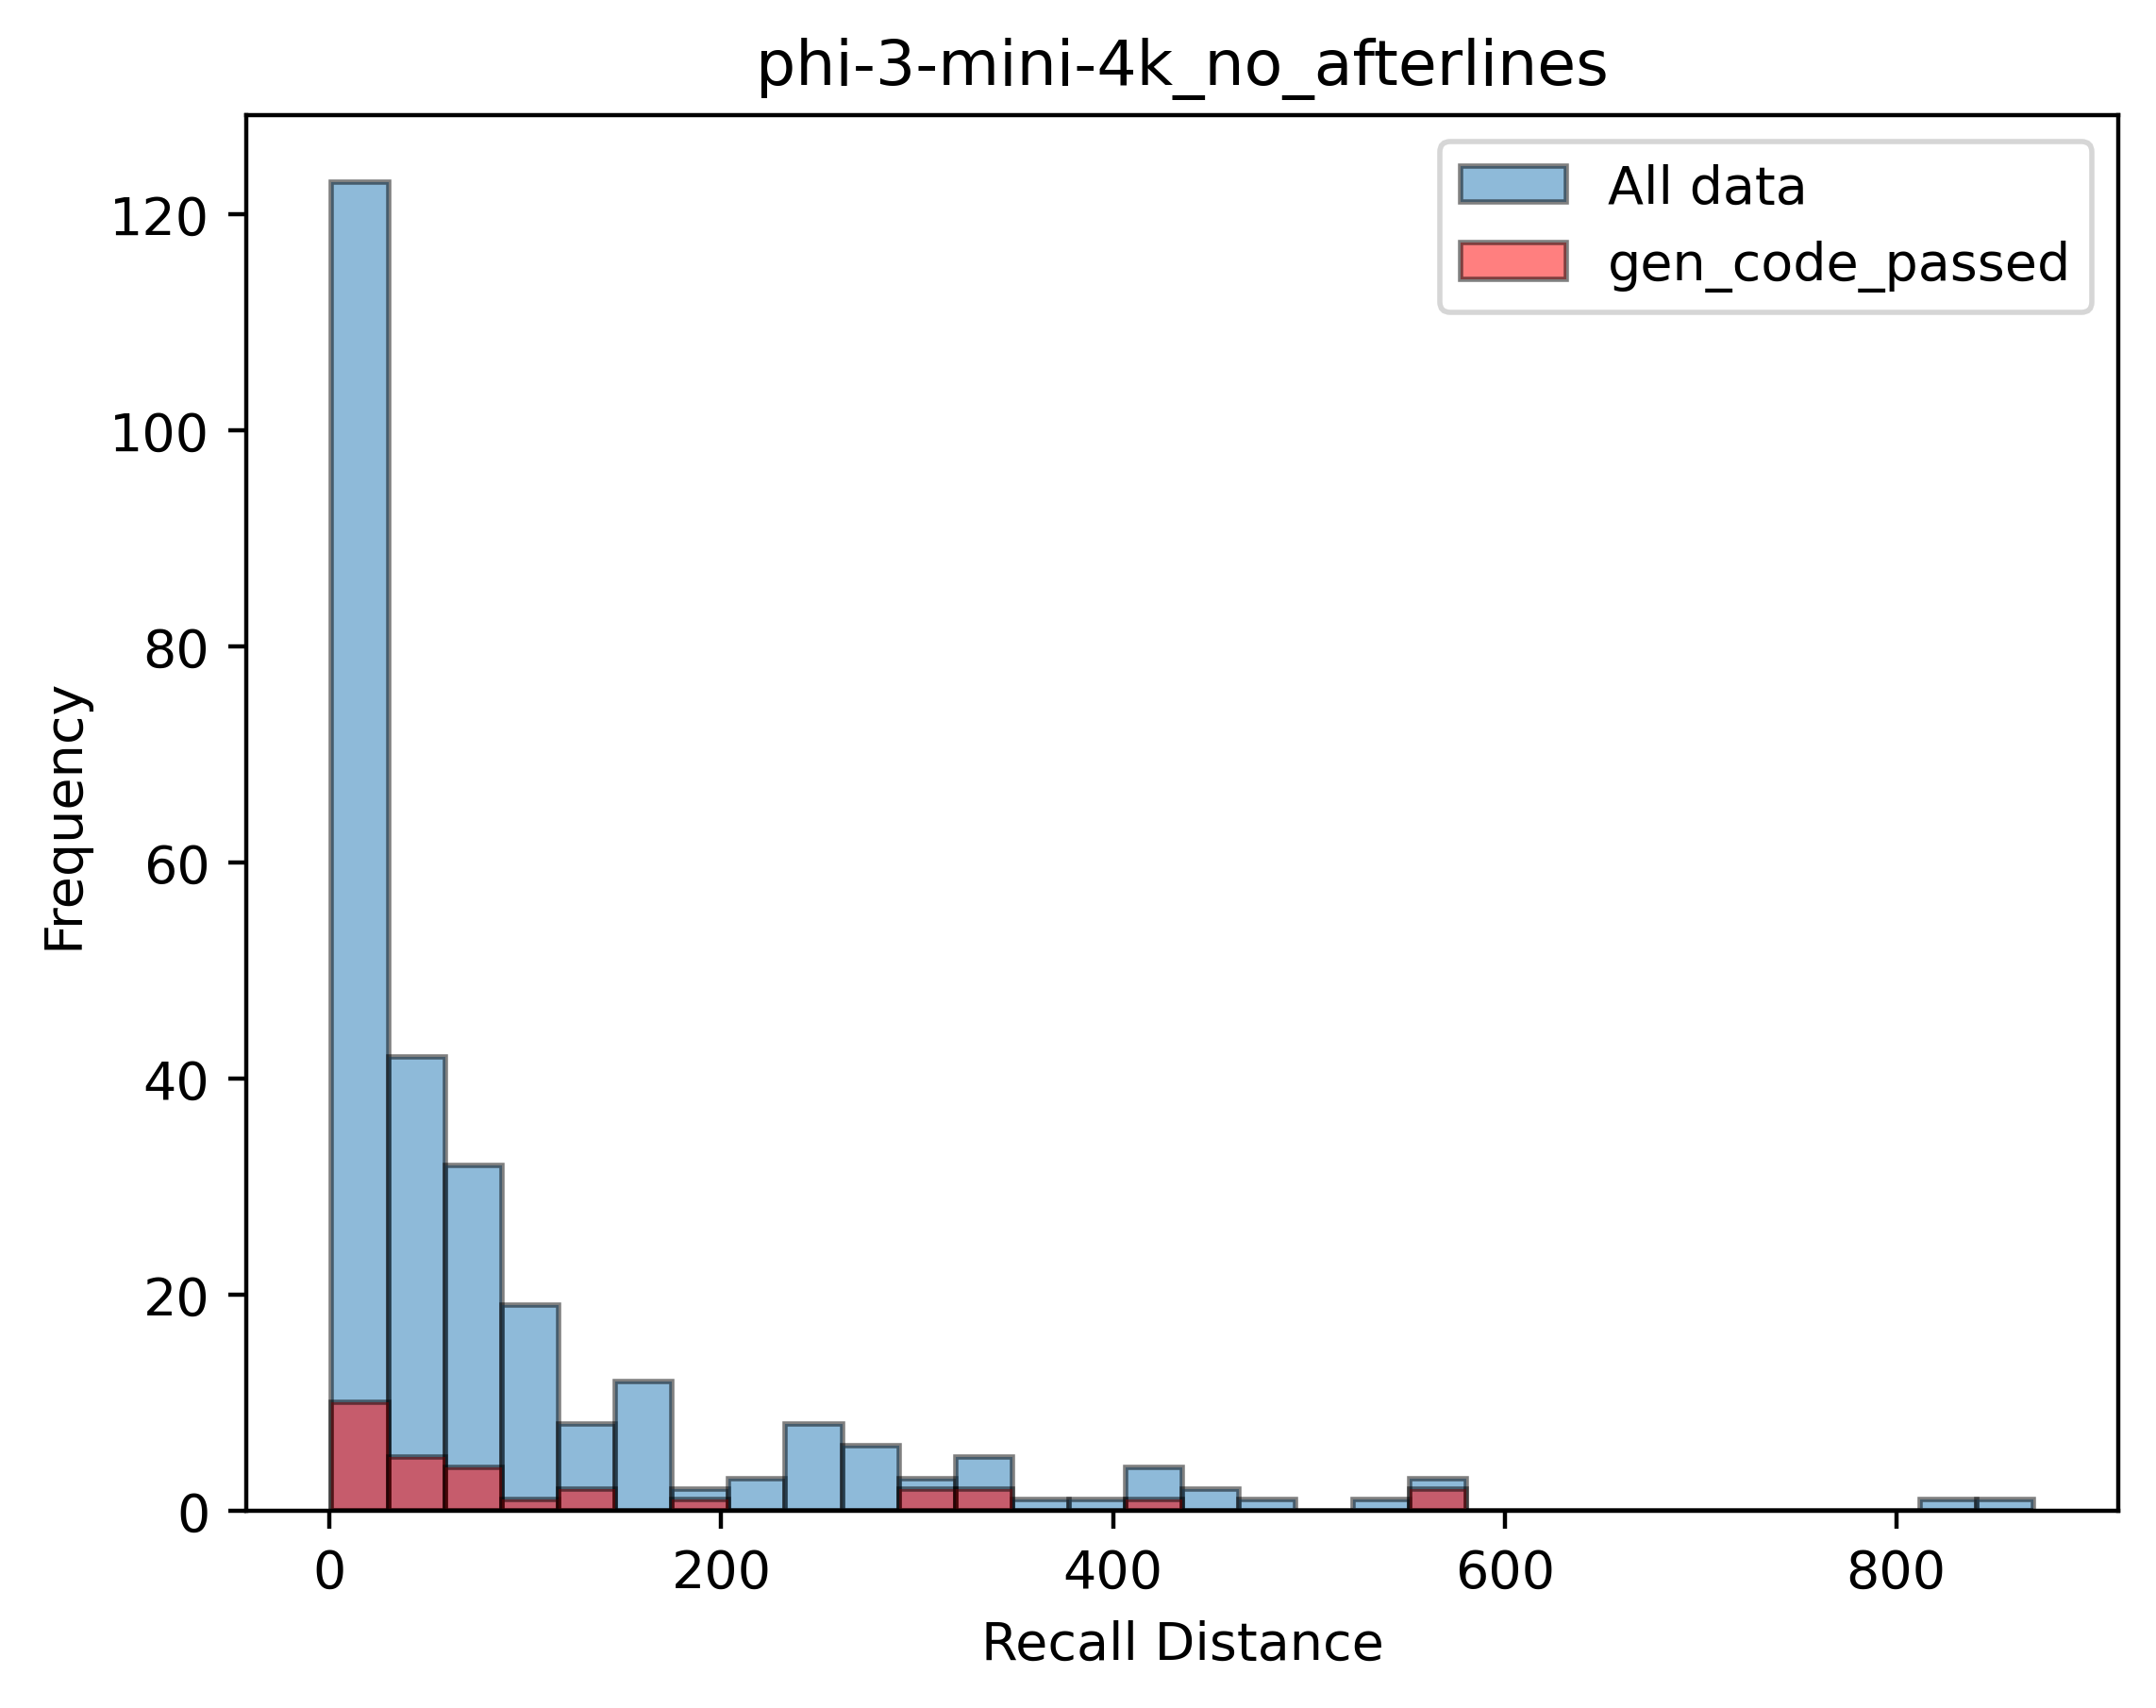

Plotting histogram for group: gpt-3.5-turbo-0125_no_afterlines


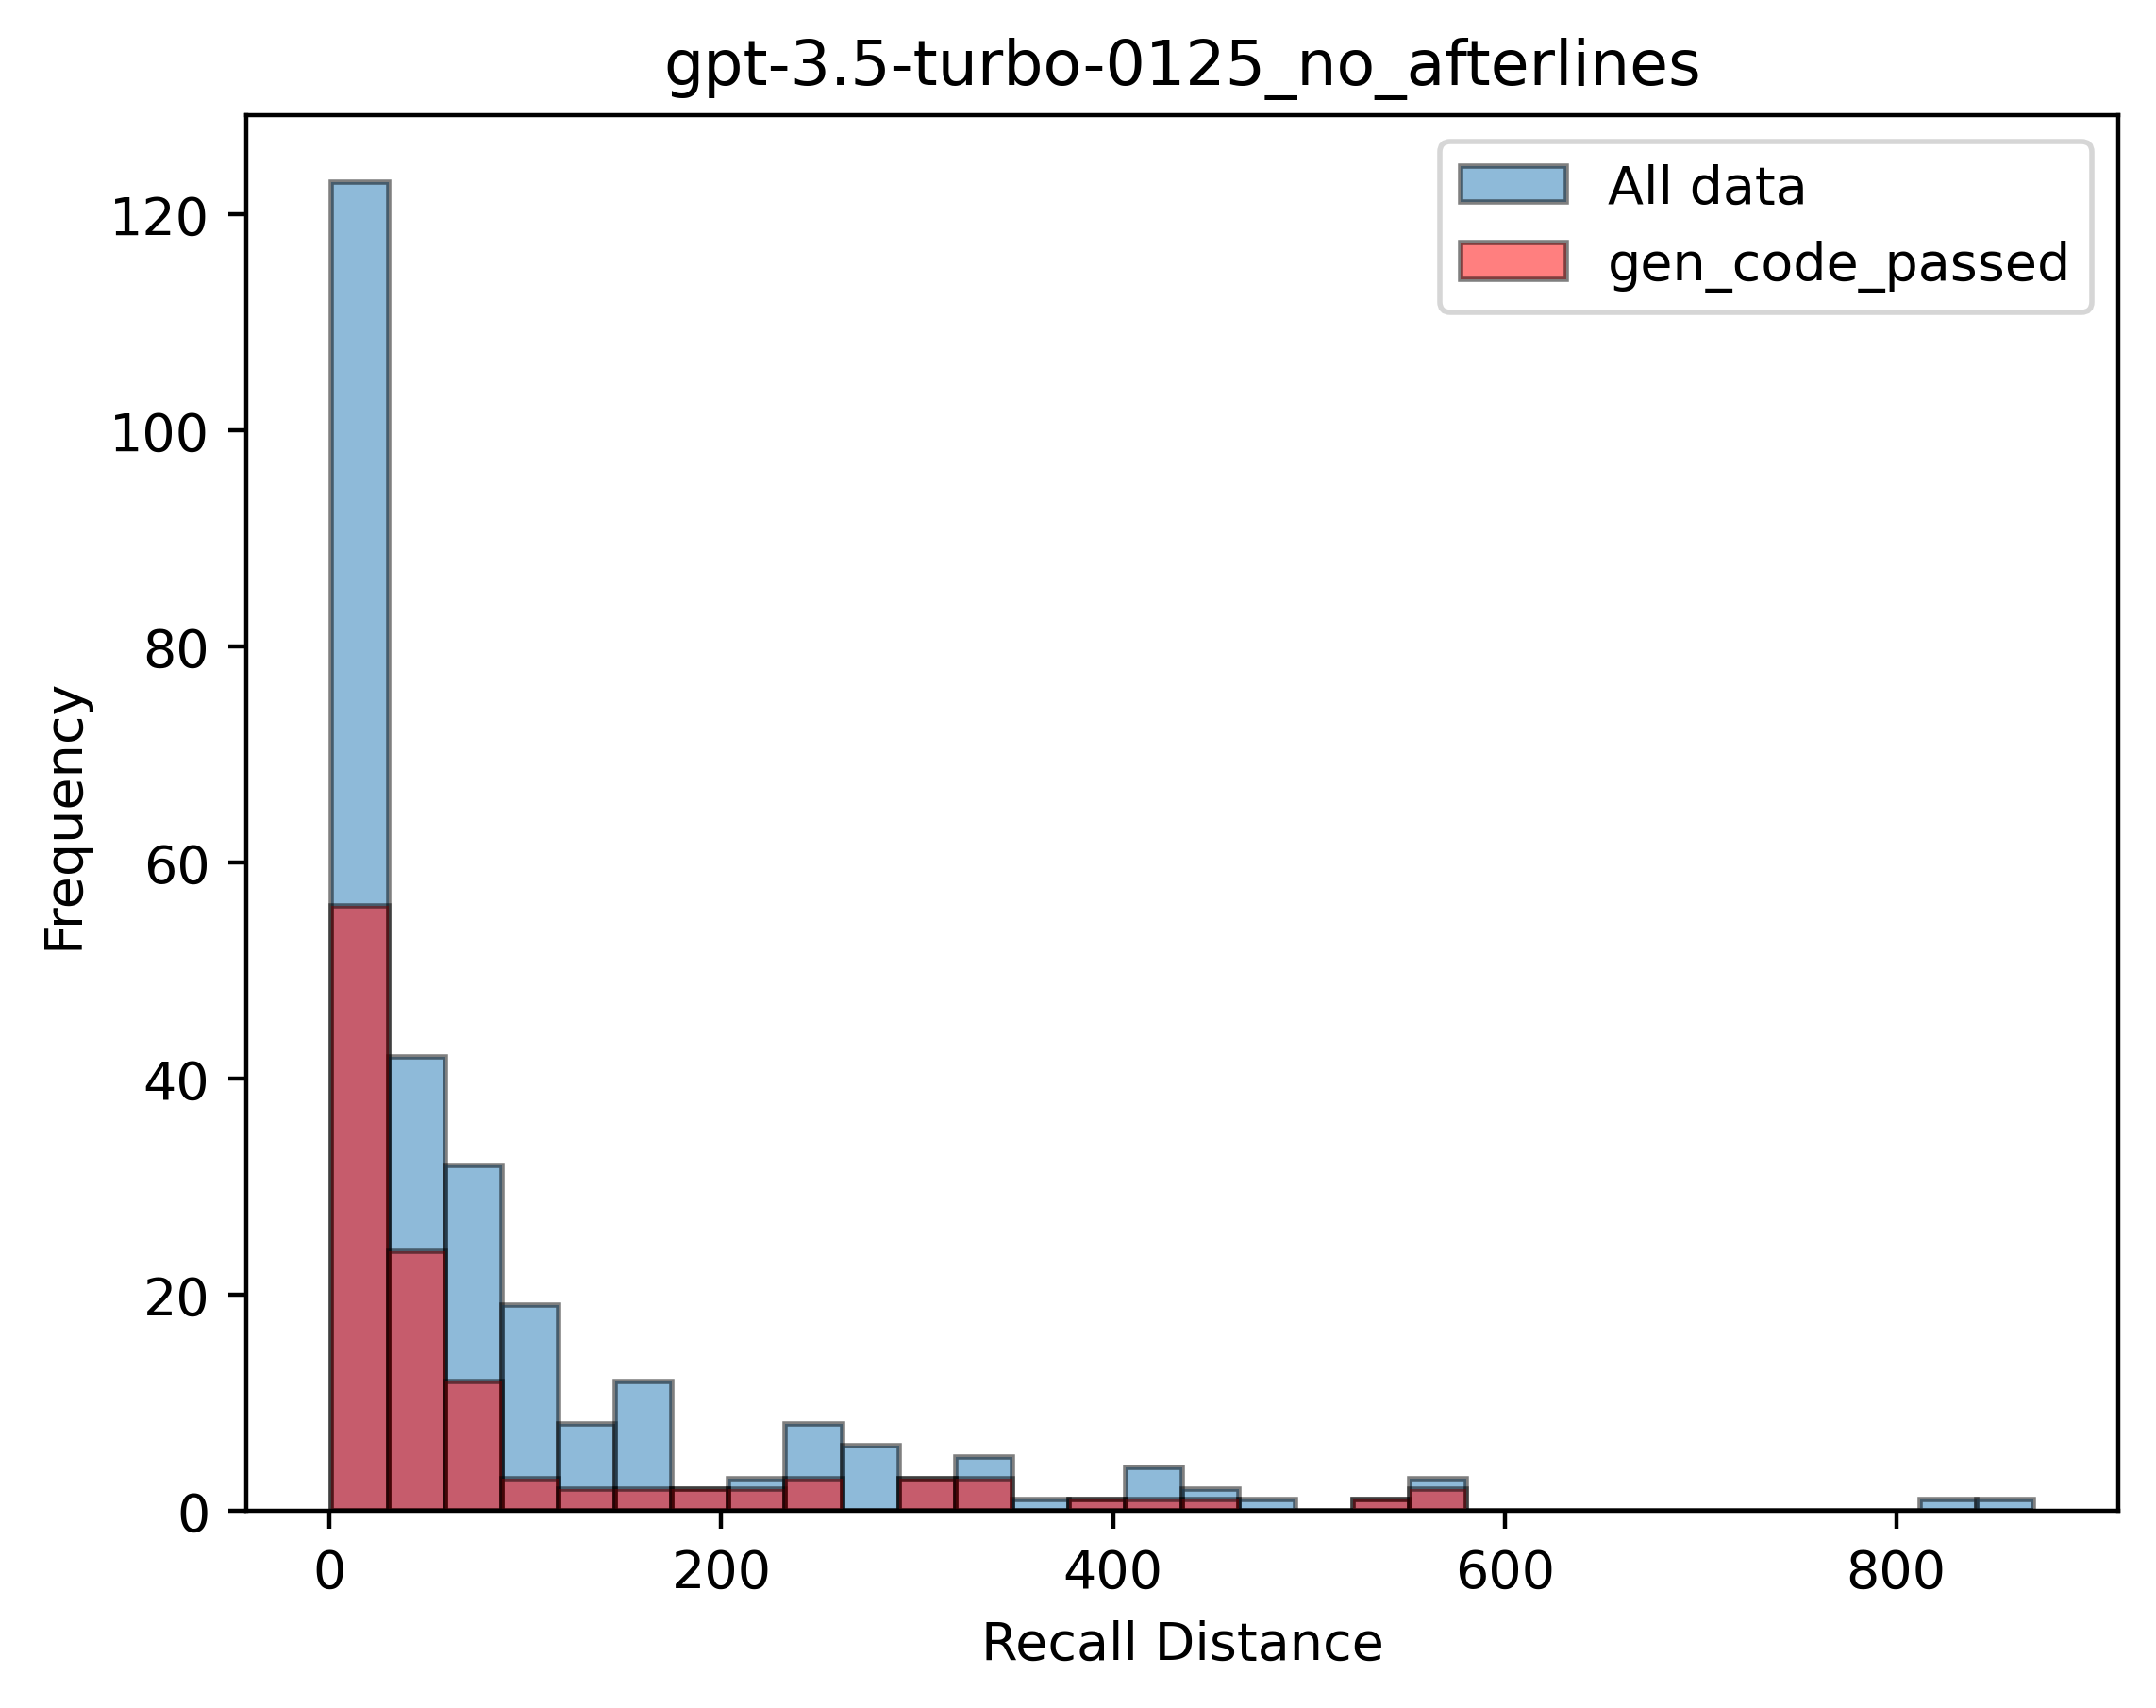

Plotting histogram for group: claude-3-opus-20240229_no_afterlines


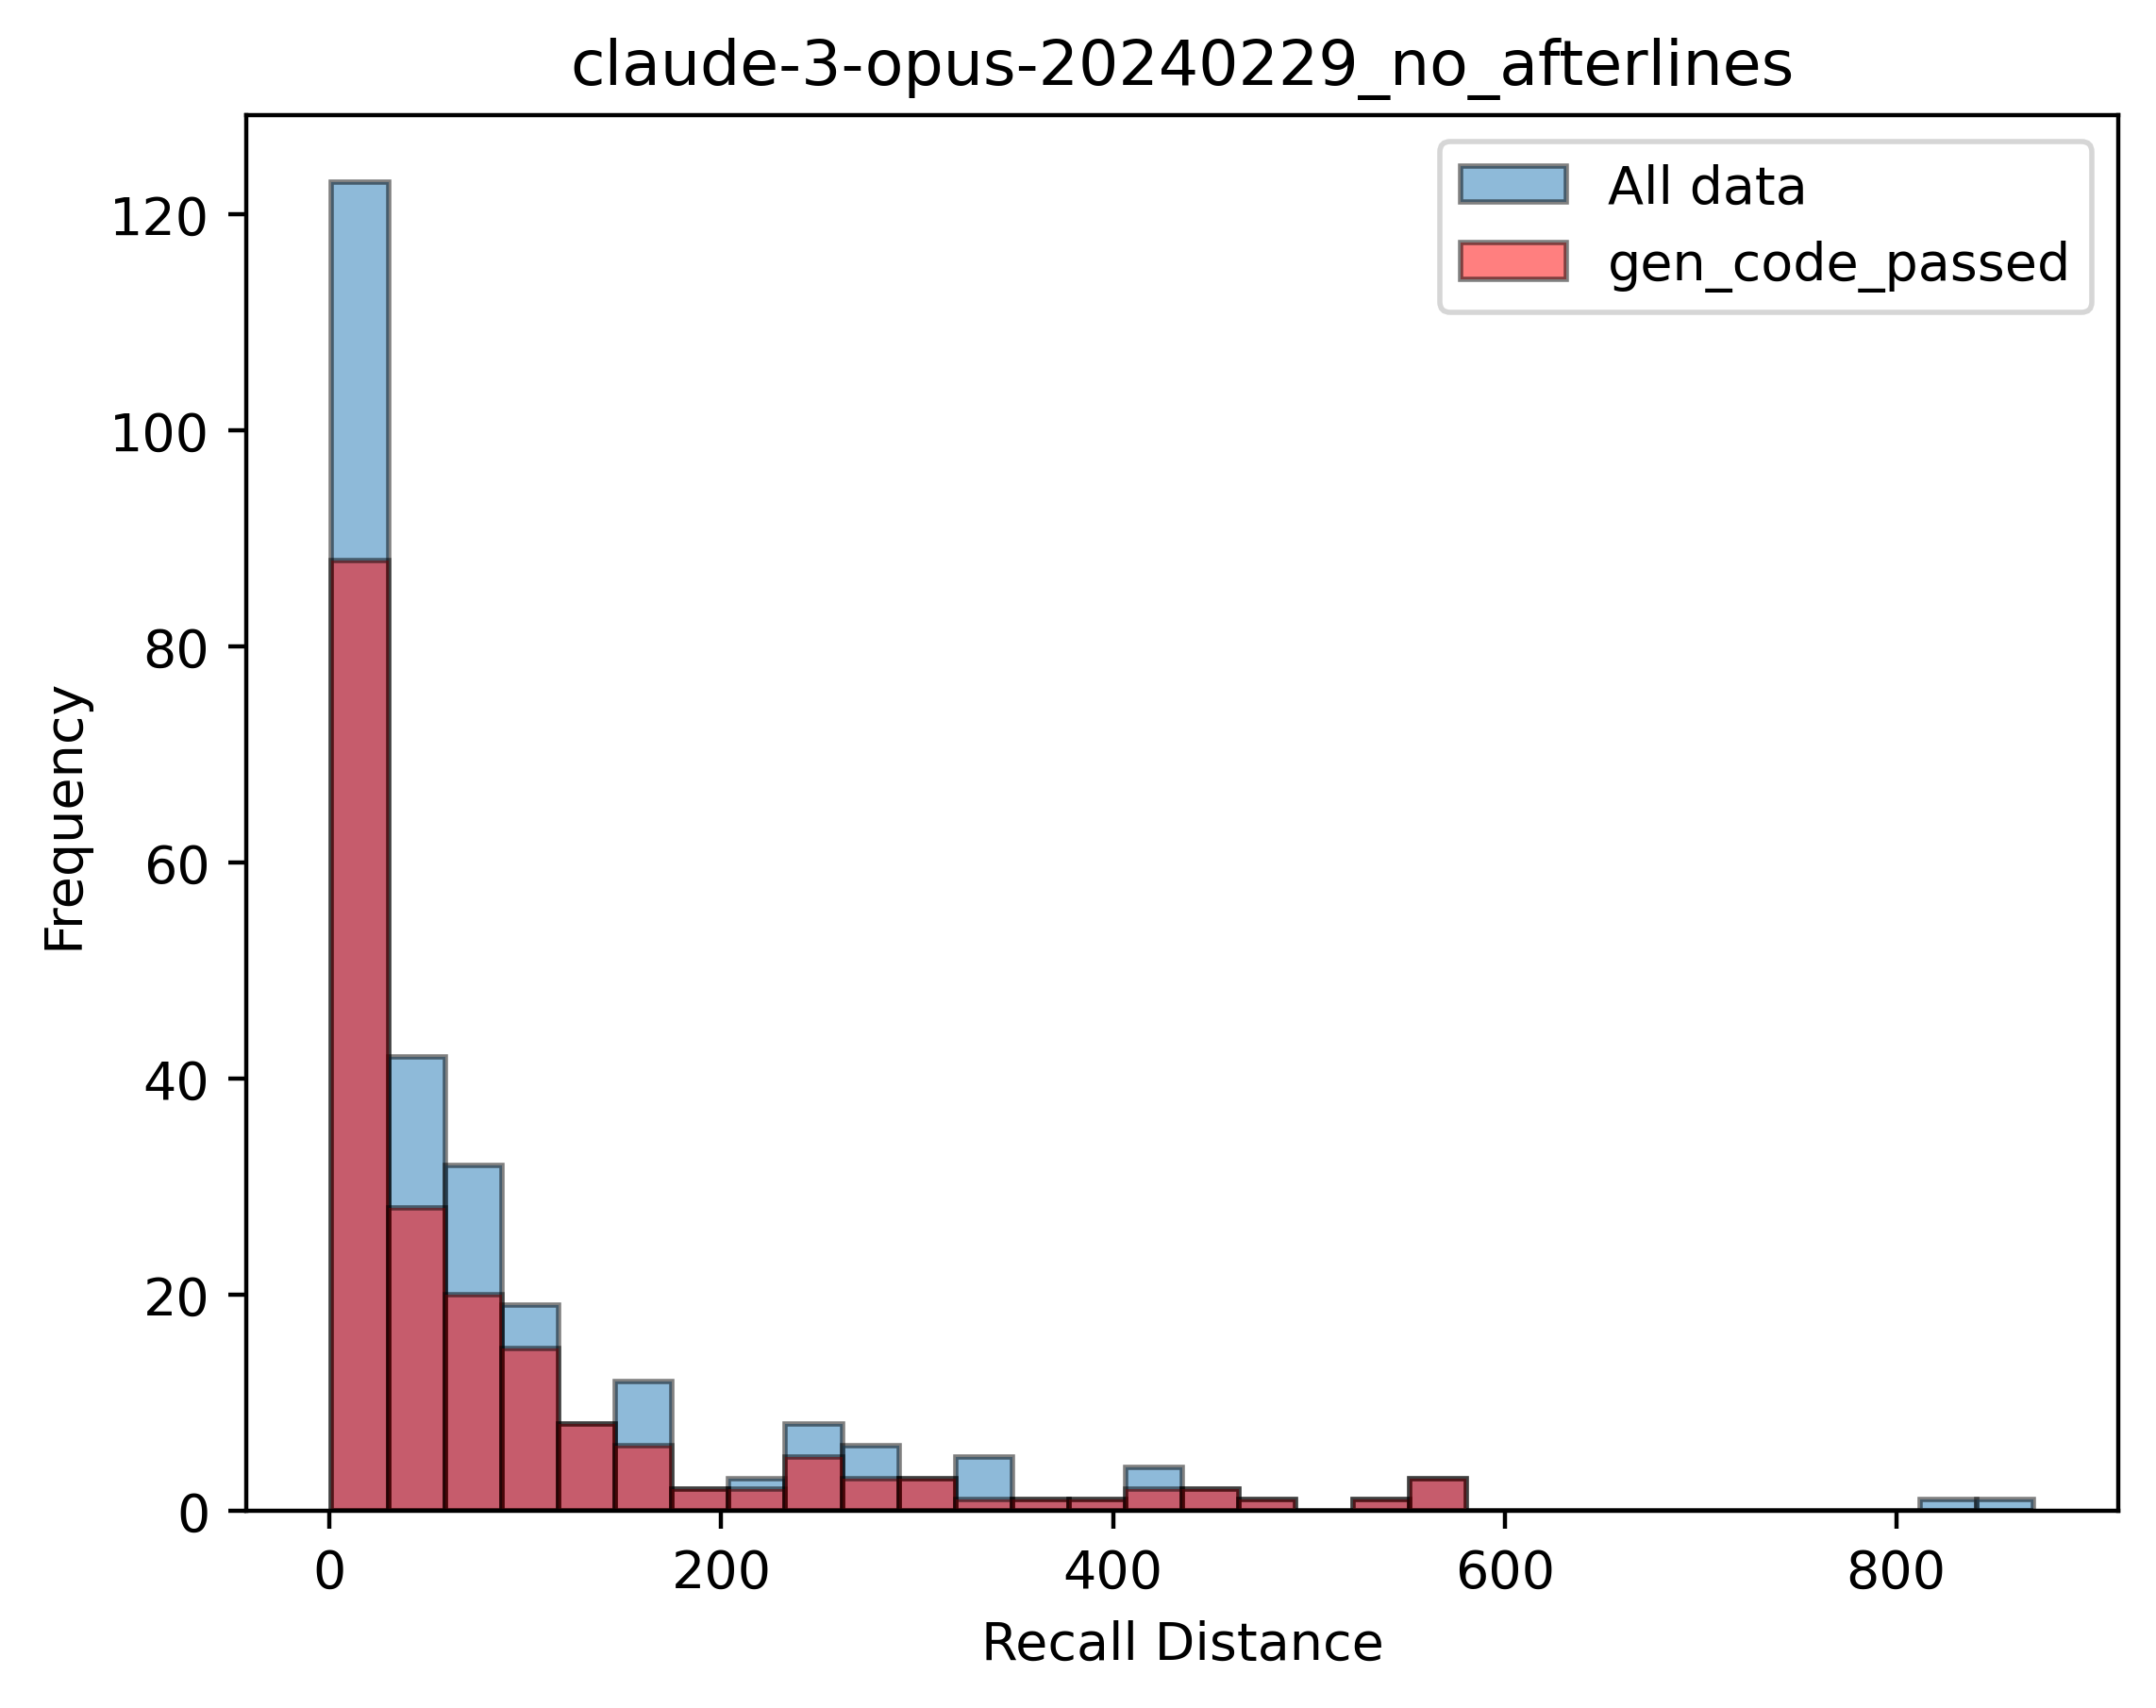

Plotting histogram for group: deepseek-coder-7b-instruct_no_afterlines


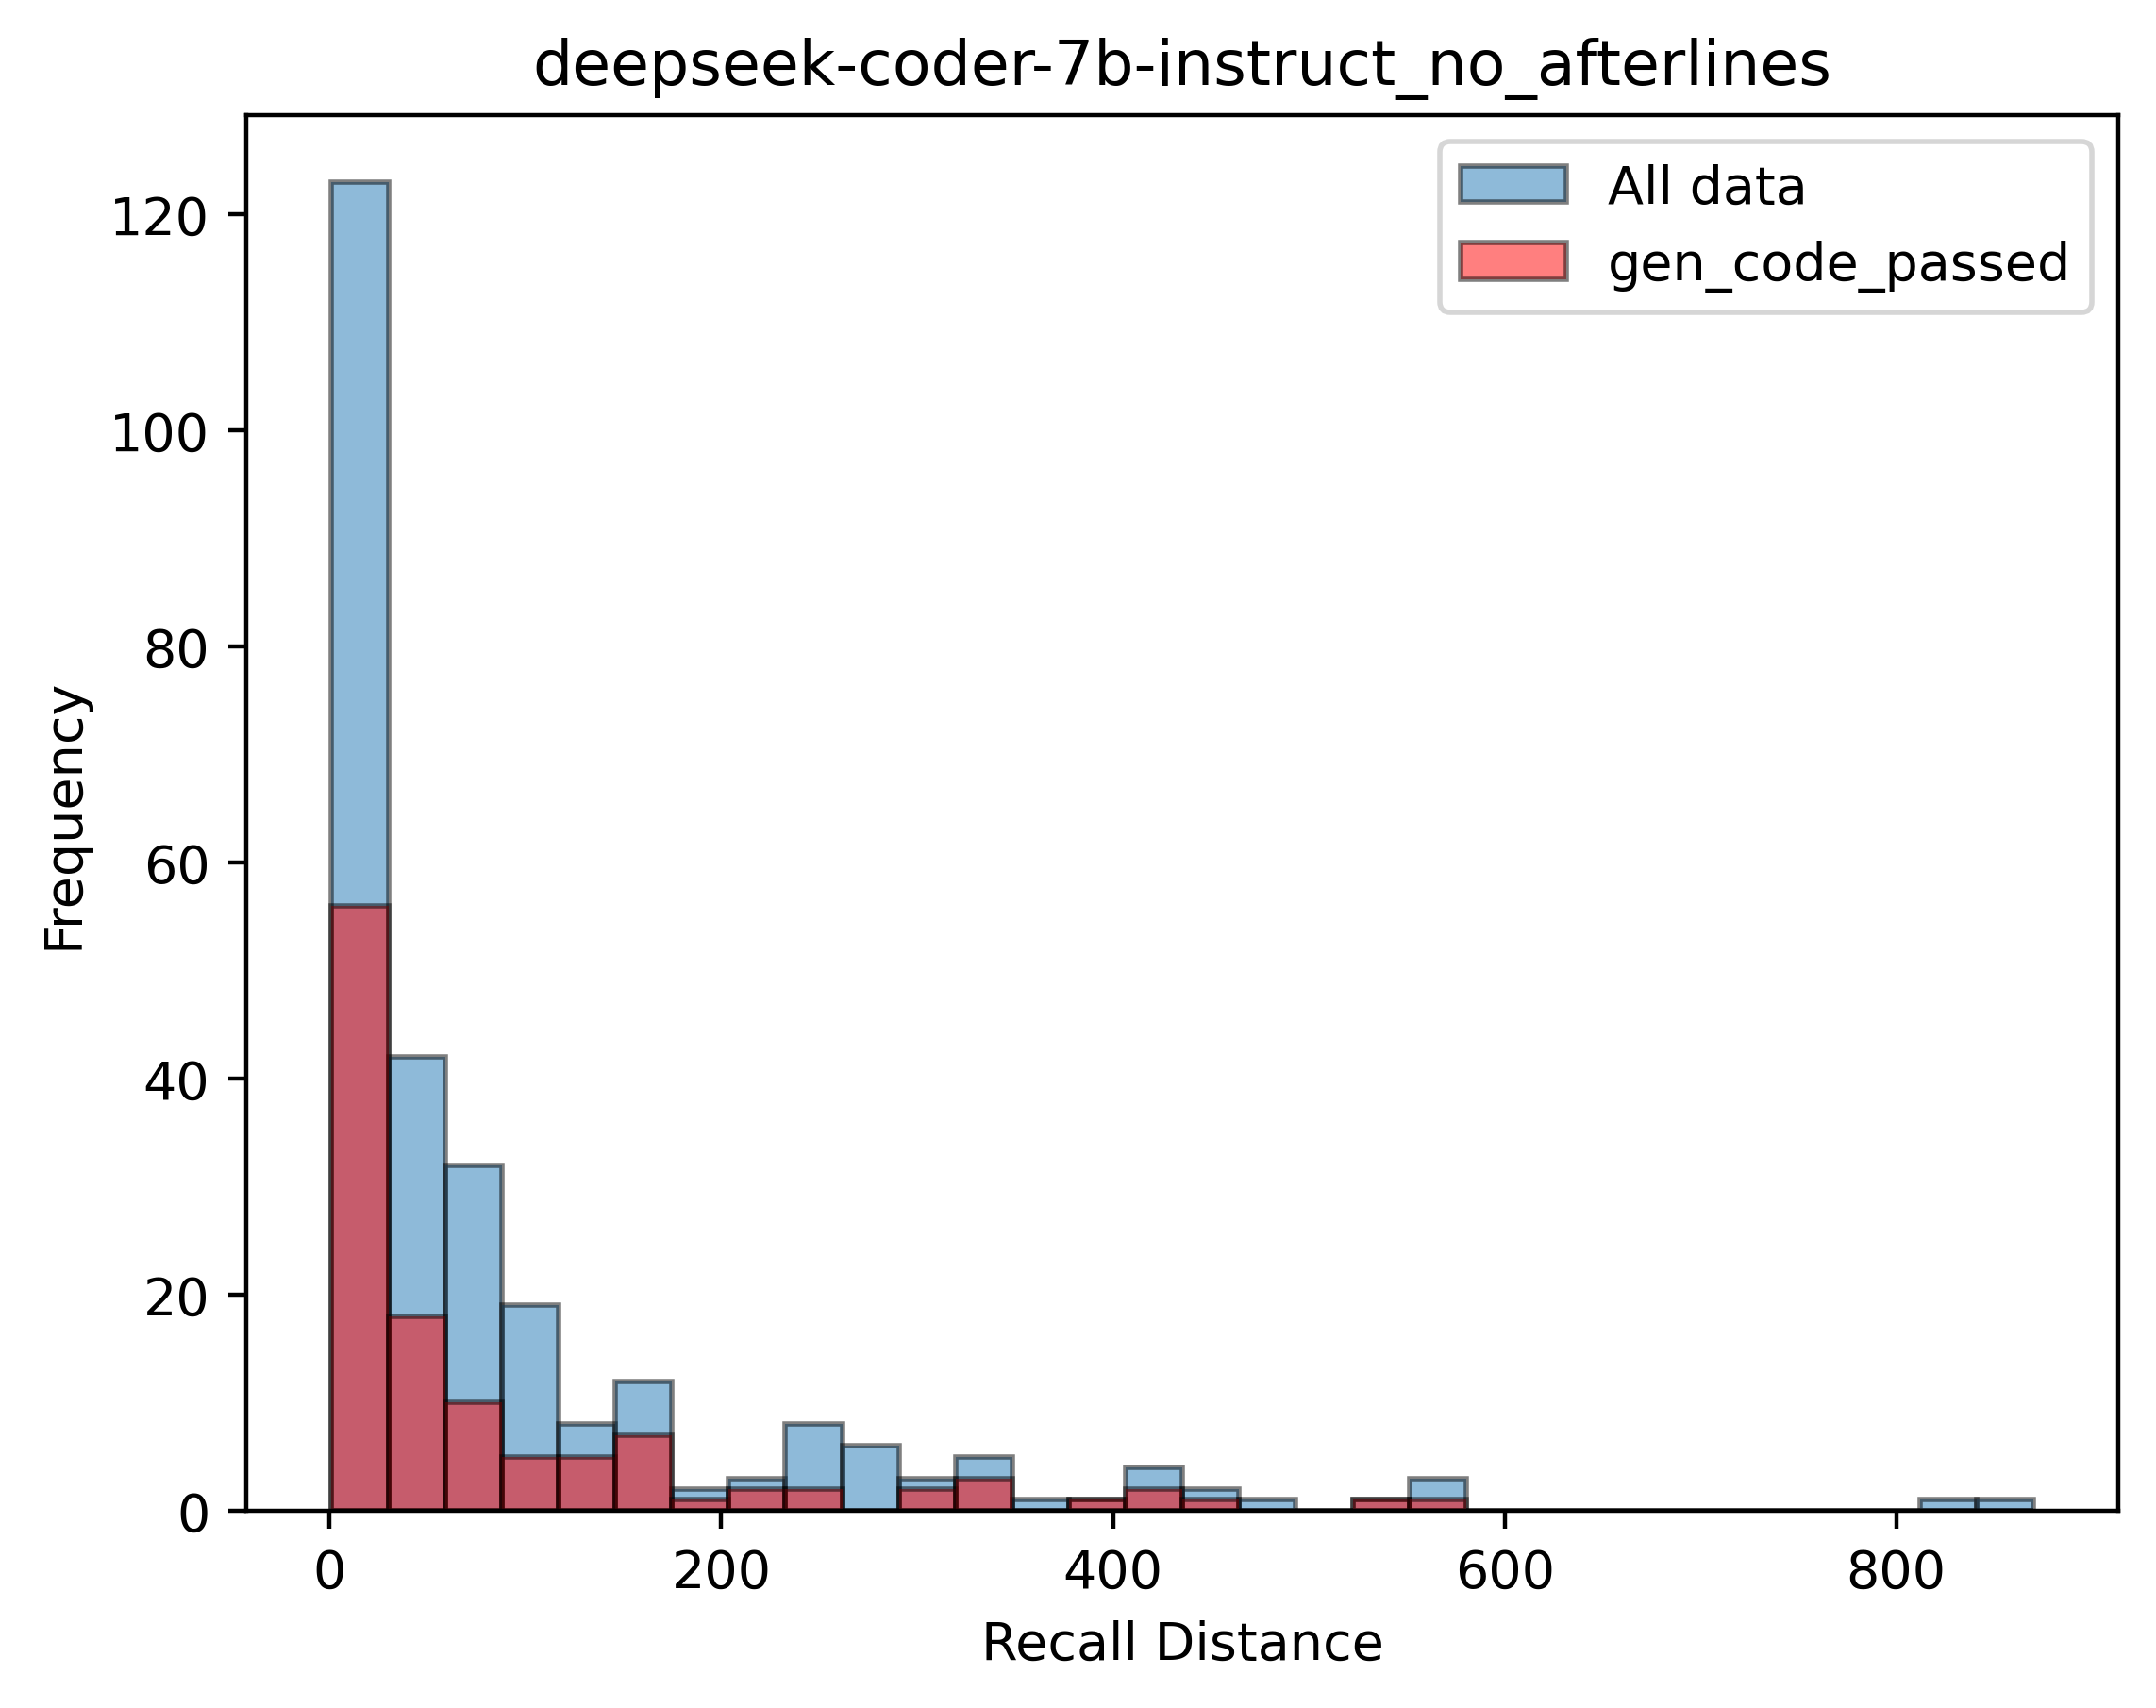

Key: Meta-Llama-3-70B-Instruct_no_afterlines


,range_class,total_counts,passed_counts,percentages
15,Short,123,59,48.00 ± 8.74
16,Medium,82,52,63.49 ± 10.45
17,Long,73,39,53.46 ± 11.34


Key: Meta-Llama-3-8B-Instruct_no_afterlines


,range_class,total_counts,passed_counts,percentages
3,Short,123,36,29.29 ± 8.11
4,Medium,82,20,24.36 ± 9.27
5,Long,73,17,23.29 ± 9.68


Key: claude-3-haiku-20240307_no_afterlines


,range_class,total_counts,passed_counts,percentages
12,Short,123,53,43.08 ± 8.81
13,Medium,82,46,56.12 ± 10.71
14,Long,73,40,54.81 ± 11.45


Key: claude-3-opus-20240229_no_afterlines


,range_class,total_counts,passed_counts,percentages
24,Short,123,88,71.54 ± 8.02
25,Medium,82,55,67.19 ± 10.21
26,Long,73,49,67.04 ± 10.82


Key: claude-3-sonnet-20240229_no_afterlines


,range_class,total_counts,passed_counts,percentages
6,Short,123,71,57.74 ± 8.78
7,Medium,82,49,59.82 ± 10.57
8,Long,73,35,48.00 ± 11.49


Key: deepseek-coder-1.3b-instruct_no_afterlines


,range_class,total_counts,passed_counts,percentages
9,Short,123,19,15.43 ± 6.35
10,Medium,82,11,13.45 ± 7.42
11,Long,73,15,20.58 ± 9.29


Key: deepseek-coder-7b-instruct_no_afterlines


,range_class,total_counts,passed_counts,percentages
27,Short,123,56,45.56 ± 8.78
28,Medium,82,31,37.70 ± 10.55
29,Long,73,30,41.06 ± 11.24


Key: gpt-3.5-turbo-0125_no_afterlines


,range_class,total_counts,passed_counts,percentages
21,Short,123,56,45.61 ± 8.84
22,Medium,82,38,46.33 ± 10.70
23,Long,73,24,32.87 ± 10.83


Key: gpt-4-turbo_no_afterlines


,range_class,total_counts,passed_counts,percentages
0,Short,123,75,60.94 ± 8.68
1,Medium,82,56,68.24 ± 10.04
2,Long,73,41,56.13 ± 11.21


Key: phi-3-mini-4k_no_afterlines


,range_class,total_counts,passed_counts,percentages
18,Short,123,10,8.14 ± 4.85
19,Medium,82,9,10.97 ± 6.76
20,Long,73,11,15.08 ± 8.21


In [14]:
# folder_path = '../Analysis_Results/Post_process/Check_pass_hist/no_instructions/Python/test_update/Updated_post_process'
# folder_path = '../Analysis_Results/Post_process/Check_pass_hist/no_instructions/Python/test_update/'
# folder_path = '../Analysis_Results/Post_process/Check_pass_hist/no_instructions/Python/test_update/Image_Transformation'
# folder_path = '../Analysis_Results/Post_process/Check_pass_hist/no_instructions/Python/test_update/deepseek_coder_postprocess/Updated_post_process'

# folder_path = '../Analysis_Results/Post_process/Check_pass_hist/no_instructions/Python/test_update/Image_Filtering/Updated_post_process'

# folder_path = '../Analysis_Results/Post_process/Check_pass_hist/no_instructions/Java'
# folder_path = '../Analysis_Results/Post_process/Check_pass_hist/no_instructions/prompt_w_read_instructions'

# folder_path = '../Analysis_Results/deepseek-coder-1.3b-instruct/Updated_post_process'
# folder_path = '../Analysis_Results/Claude-3/2nd_run_Python_Infilling/Updated_post_process'

# folder_path = '../Analysis_Results/storage_server/Python_all_res/Infilling/Updated_post_process'
# folder_path = '../Analysis_Results/storage_server/Java_all_res/Infilling/Updated_post_process'

# folder_path = '../Analysis_Results/storage_server/Python_all_res/Completion/Updated_post_process'
# folder_path = '../Analysis_Results/storage_server/Java_all_res/Completion'

# folder_path = '../Analysis_Results/storage_server/Python_all_res/Completion/2nd_post_process/Updated_post_process'

# folder_path = '../Analysis_Results/storage_server/Python_all_res/Infilling/2nd_post_process/Updated_post_process'
# folder_path = '../Analysis_Results/storage_server/Python_all_res/Infilling/2nd_post_process/Updated_post_process'


# folder_path = '../Analysis_Results/storage_server/phi-3/phi-3-mini-4k/Python/Infilling/Updated_post_process'
# folder_path = '../Analysis_Results/storage_server/phi-3/phi-3-mini-4k/Python/Infilling/phi-3-mini-4k-python/Updated_post_process'

# folder_path = '../Analysis_Results/storage_server/phi-3/phi-3-mini-4k/Python/Infilling/phi-3-mini-4k-python/Updated_post_process'

##########################

# #Python All Res
# ##########################
# # folder_path = '../Analysis_Results/storage_server/Python_all_res/Combine_Completion_Infill'
# # folder_path = '../Analysis_Results/storage_server/Python_all_res/Infilling/2nd_post_process/Updated_post_process'
# # folder_path = '../Analysis_Results/storage_server/Python_all_res/Completion/2nd_post_process/Updated_post_process'

# #Java All Res
# ##########################
# # folder_path = '../Analysis_Results/storage_server/Java_all_res/Combine_Completion_Infill'
# # folder_path = '../Analysis_Results/storage_server/Java_all_res/Infilling/2nd_post_process/Updated_post_process'
# folder_path = '../Analysis_Results/storage_server/Java_all_res/Completion/2nd_post_process/Updated_post_process'

#Python All Res
##########################
# folder_path = '../Analysis_Results/storage_server/Python_all_res/Completion/4th_post_process_reason_update/Update_labels'
# folder_path = '../Analysis_Results/storage_server/Python_all_res/Infilling/4th_post_process_reason_update/Update_labels'

#Java All Res
##########################
folder_path = '../Analysis_Results/storage_server/Java_all_res/Completion/4th_post_process_reason_update/Update_labels'
# folder_path = '../Analysis_Results/storage_server/Java_all_res/Infilling/4th_post_process_reason_update/Update_labels'


# Set the global variable
# col_to_check = 'gen_code_pass_ratio'
col_to_check = 'post_process_pass_ratio'
combined_df = process_and_plot(folder_path, col_to_check)


# Set the short and medium ranges
# Potential Setting for Java
process_and_display(combined_df, 30, 100)
# Potential Setting for Python
# process_and_display(combined_df, 10, 30)

In [12]:


bootstrap_resampling(33,54)

(0.6106870370370371, 0.12824142353948995)